<a href="https://colab.research.google.com/github/PriyankaDodeja/News-Popularity-Prediction/blob/EDA/News_Popularity_Prediction_in_Social_Media_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the news popularity in multiple social media platforms. </u></b>

## <b> Problem Description </b>

### This is a large data set of news items and their respective social feedback on multiple platforms: Facebook, Google+ and LinkedIn.The collected data relates to a period of 8 months, between November 2015 and July 2016, accounting for about 100,000 news items on four different topics: Economy, Microsoft, Obama and Palestine.


## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### IDLink (numeric): Unique identifier of news items
* ### Title (string): Title of the news item according to the official media sources
* ### Headline (string): Headline of the news item according to the official media sources
* ### Source (string): Original news outlet that published the news item
* ### Topic (string): Query topic used to obtain the items in the official media sources
* ### PublishDate (timestamp): Date and time of the news items' publication
* ### SentimentTitle (numeric): Sentiment score of the text in the news items' title
* ### SentimentHeadline (numeric): Sentiment score of the text in the news items' headline
* ### Facebook (numeric): Final value of the news items' popularity according to the social media source Facebook
* ### GooglePlus (numeric): Final value of the news items' popularity according to the social media source Google+
* ### LinkedIn (numeric): Final value of the news items' popularity according to the social media source LinkedIn


### VARIABLES OF SOCIAL FEEDBACK DATA

* ### IDLink (numeric): Unique identifier of news items
* ### TS1 (numeric): Level of popularity in time slice 1 (0-20 minutes upon publication)
* ### TS2 (numeric): Level of popularity in time slice 2 (20-40 minutes upon publication)
* ### TS... (numeric): Level of popularity in time slice ...
* ### TS144 (numeric): Final level of popularity after 2 days upon publication

# **Introduction**
---


XXXXXX

# **Installing Dependencies**
---
- We are using textblob library to work with textual data. 
- Further in the project, we would require to tune the hyperparameters of Machine Learning models for better performance.
- But due to the huge amount of training data sets, the traditional tuning models are not efficient (in terms of time taken) to work with, like GridSerachCV and RandomizedSearchCV. 
- So, we decided to move with the latest tuning model called ***HalvingRandomizedSearchCV***, which is available in the latest version of scikit-learn i.e. *0.24.2*.
- Catboost is a Machine Learning model.
- Installing shap for visualisation of feature importance.

In [ ]:
!pip install -U textblob
!pip install catboost

!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install shap

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


# **Importing Libraries**

In [ ]:
#@title

import numpy as np
import pandas as pd

# Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Sklearn Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor


# Model Libraries
import catboost as cb
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor


# Miscellaneous Libraries
from datetime import datetime
import time
import calendar
import shap

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
import IPython

import warnings
warnings.filterwarnings('ignore')


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Reading Datasets**
---

Let's read the datasets we have to work on! We have 4 Social Media feedback datasets of each dependent variable, i.e. in total we have 12 time-series datasets and 1 news data set.

In [ ]:
sources= ['Facebook', 'GooglePlus', 'LinkedIn']
topics = ['Economy','Microsoft', 'Obama', 'Palestine']

folder_path = '/content/drive/MyDrive/AlmaBetter/Capstone Projects/News Popularity Prediction/data/'
master_df = pd.read_csv(folder_path+'News_Final.csv')
df = {}
for source in sources:
  for topic in topics:
    file_name = f'{source}_{topic}.csv'
    file_path = f'{folder_path}{file_name}'
    df[f'{source}_{topic}'] = pd.read_csv(file_path)

# **Data Wrangling**
---

- Data wrangling is the process of cleaning and unifying messy and complex data sets for easy access and analysis.

- This process typically includes manually converting and mapping data from one raw form into another format to allow for more convenient consumption and organization of the data.

*Let's dive into the datasets!*

### **Datasets:**
- Social Media Feedback Datasets (12 Datasets)
- News Dataset

## **1. Social Media Feedback Datasets (12 Datasets)**
---

- These datasets have popularities of news upon every 20 minutes of publication. 

- It consists of 145 columns and N rows, where N is the number of news appeared on that particular social media platform and of that particular topic.

### **Columns:**
> **IDLink:** Unique identifier of news item.

> **TS1:** Popularity level in time slice 1 (0-20 minutes upon publication)

> **TS2:** Popularity level in time slice 2 (20-40 minutes upon publication)

>  ....

> **TS144:** Final level of popularity after 2 days upon publication.

*Let's have a look into one of those datasets,*

In [ ]:
df['Facebook_Microsoft'].head()

,IDLink,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,TS11,TS12,TS13,TS14,TS15,TS16,TS17,TS18,TS19,TS20,TS21,TS22,TS23,TS24,TS25,TS26,TS27,TS28,TS29,TS30,TS31,TS32,TS33,TS34,TS35,TS36,TS37,TS38,TS39,...,TS105,TS106,TS107,TS108,TS109,TS110,TS111,TS112,TS113,TS114,TS115,TS116,TS117,TS118,TS119,TS120,TS121,TS122,TS123,TS124,TS125,TS126,TS127,TS128,TS129,TS130,TS131,TS132,TS133,TS134,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144
0,101,-1,-1,-1,-1,-1,30,30,30,30,30,52,52,55,55,55,55,55,55,73,73,73,73,73,73,73,73,73,87,87,87,90,91,92,92,93,93,96,102,102,...,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,129,129,129,129,129,131,131,131,131,131,131,131,131,131,131,131,131,131,131,133,133
1,102,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,16,16,16,16,16,23,23,25,25,25,25,25,25,28,28,28,28,28,28,...,54,54,54,54,54,54,54,56,56,56,56,56,56,56,56,56,56,56,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,58,58,58
2,103,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,180,180,180,180,180,187,187,...,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,260,260,260,260,261,262,262,263
3,104,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,12,12,12,12,12,12,12,...,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
4,105,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,185,185,185,185,185,188,188,...,277,277,277,286,289,289,296,296,296,300,303,303,303,307,307,307,307,307,307,310,310,312,312,312,312,312,313,313,313,313,314,314,315,315,316,316,316,316,316,316


In [ ]:
# Checking Null values 
for d in df:
    print(f'Null Values of {d}:',sum(df[d].isna().sum()))

Null Values of Facebook_Economy: 0
Null Values of Facebook_Microsoft: 0
Null Values of Facebook_Obama: 0
Null Values of Facebook_Palestine: 0
Null Values of GooglePlus_Economy: 0
Null Values of GooglePlus_Microsoft: 0
Null Values of GooglePlus_Obama: 0
Null Values of GooglePlus_Palestine: 0
Null Values of LinkedIn_Economy: 0
Null Values of LinkedIn_Microsoft: 0
Null Values of LinkedIn_Obama: 0
Null Values of LinkedIn_Palestine: 0


## **Observations:**
---
- All other datasets are similar to the dataset shown above.
- They have no null values.
- TS144 is the dependent variable of the news dataset.
- -1 level of popularity means the news item hasn't come to the platform yet.
- 0 level of popularity means the news item has landed the platform but is not at all popular as of now.
- 1 level of popularity means the news item's popularity has increased to 1 and so on.

## **2. News Dataset**
---
This dataset contains all the information related to the news item. It consist of 93239 rows and 11 columns.


### **Columns:**

> **IDLink:** Unique identifier of news item.

> **Title:** Title of the news item.

> **Headline:** Headline of the news item.

> **Source:** Original news outlet that published the news item.

> **Topic:** Topic of the news item.

> **PublishDate:** Date on which the news item got published.

> **SentimentTitle:** It is the sentiment title score.

> **SentimentHeadline:** It is the sentiment headline score.

> **Dependent Variables:**

- **Facebook:** Popularity after 2 days on Facebook platform upon publication.

- **GooglePlus:** Popularity after 2 days on GooglePlus platform upon publication.

- **LinkedIn:** Popularity after 2 days on LinkedIn platform upon publication.

In [ ]:
news_df = pd.read_csv(folder_path+'News_Final.csv')
master_df = news_df.copy()
master_df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [ ]:
master_df.shape

(93239, 11)

In [ ]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93239 entries, 0 to 93238
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             93239 non-null  float64
 1   Title              93239 non-null  object 
 2   Headline           93224 non-null  object 
 3   Source             92960 non-null  object 
 4   Topic              93239 non-null  object 
 5   PublishDate        93239 non-null  object 
 6   SentimentTitle     93239 non-null  float64
 7   SentimentHeadline  93239 non-null  float64
 8   Facebook           93239 non-null  int64  
 9   GooglePlus         93239 non-null  int64  
 10  LinkedIn           93239 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 7.8+ MB


In [ ]:
master_df.describe()

,IDLink,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
count,93239.000000,93239.000000,93239.000000,93239.000000,93239.000000,93239.000000
mean,51560.653257,-0.005411,-0.027493,113.141336,3.888362,16.547957
std,30391.078704,0.136431,0.141964,620.173233,18.492648,154.459048
min,1.000000,-0.950694,-0.755433,-1.000000,-1.000000,-1.000000
25%,24301.500000,-0.079057,-0.114574,0.000000,0.000000,0.000000
50%,52275.000000,0.000000,-0.026064,5.000000,0.000000,0.000000
75%,76585.500000,0.064255,0.059709,33.000000,2.000000,4.000000
max,104802.000000,0.962354,0.964646,49211.000000,1267.000000,20341.000000


### **Observations:**
---
- Title and Headline columns contain textual data. We would require to use TfidfVectorizer or CountVectorizer to deal with them.
- Topic is the categorical column.
- Source and Headline column contains some null values.
- -1 level of popularity shows that the particular news item didn't land on the platform in two days upon publication.
- We also have data whose popularity in all the social media platforms (Dependent Features) is -1. This implies that those are trash data.

## **Data Cleaning and Refactoring**
---
Let's reformat and clean the data for smooth processing!

### **Dealing with negative popularities**

- We have negative popularities in Social Media Feedback datasets and news dataset.
- It was quite difficult to deal with negative popularities while data scaling, predicting, EDA, etc. So, we decided to increase all the levels of popularities by 1.
- This, in turn, makes 0 level of popularity as news item not landed on the platform yet upon publication, and so on.
- This step won't affect our prediction or analysis. It will only make it easier to deal with the data.

In [ ]:
# Increasing Popularity level by 1 to deal with -1 level
for col in sources:
    master_df[col] = master_df[col].apply(lambda x:x+1)

for idf in df:
    for col in df[idf]:
        if col == 'IDLink':
            continue
        df[idf][col] += 1

In [ ]:
df['Facebook_Economy'].head()

,IDLink,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,TS11,TS12,TS13,TS14,TS15,TS16,TS17,TS18,TS19,TS20,TS21,TS22,TS23,TS24,TS25,TS26,TS27,TS28,TS29,TS30,TS31,TS32,TS33,TS34,TS35,TS36,TS37,TS38,TS39,...,TS105,TS106,TS107,TS108,TS109,TS110,TS111,TS112,TS113,TS114,TS115,TS116,TS117,TS118,TS119,TS120,TS121,TS122,TS123,TS124,TS125,TS126,TS127,TS128,TS129,TS130,TS131,TS132,TS133,TS134,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144
0,1,0,0,0,0,0,0,0,0,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,...,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
1,2,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,16,16,16,18,18,19,19,20,20,...,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,93,94,94,95,96,97,98,98,98,98,98,98,98,98,98,98,98,98,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35


In [ ]:
# Check Null values

print(master_df.isna().sum())
print(master_df.Source.value_counts()[:3])

IDLink                 0
Title                  0
Headline              15
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64
Bloomberg    1732
Reuters      1321
ABC News     1098
Name: Source, dtype: int64


### **Dealing with Null/Missing Data**
- Source column contains 279 *Null values*. Let us fill these null values with the source that has published maximum number of news items, i.e. Bloomberg.
- Headline column contains 15 *Null values*. It is very less as compared to number of rows. So, let's drop all the rows that has null values of this column

**Working on PublishDate Column**
- We have separated the date and the time into separate columns for the ease of working and analysis.

In [ ]:
# Handling Missing Value and Cleaning
master_df[master_df['Source'].isna()].Source = 'Bloomberg'
master_df['Source'].fillna('Bloomberg', inplace = True)
master_df.dropna(inplace = True)

# PublishDate change type to datetime from object
def convert_to_dt(df):
  df['PublishDate'] = pd.to_datetime(df['PublishDate'])
  df['PublishTime'] = df['PublishDate'].dt.time
  df['PublishDate'] = df['PublishDate'].dt.date

convert_to_dt(master_df)

# Extracting Day of the Week
master_df['Weekday'] = master_df.PublishDate.apply(lambda x: calendar.day_name[x.weekday()])

# #Change IDLink datatype to string
# master_df['IDLink'] = master_df['IDLink'].astype(int).astype(str)
master_df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,PublishTime,Weekday
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02,0.000000,-0.053300,0,0,0,00:00:00,Tuesday
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20,0.208333,-0.156386,0,0,0,00:00:00,Saturday
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28,-0.425210,0.139754,0,0,0,00:00:00,Saturday
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01,0.000000,0.026064,0,0,0,00:06:00,Sunday
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01,0.000000,0.141084,0,0,0,00:11:00,Sunday


In [ ]:
# Converting source values to lower - We found out that some values of
# source columns are present more than once in different cases.

print('No. of Sources:',len(list(master_df['Source'].unique())))
print('No. of Distinct Sources:',len(list(master_df['Source'].apply(lambda x:x.lower()).unique())))

No. of Sources: 5755
No. of Distinct Sources: 5740


### **Trash Data**


**Date Range restriction**

- It is clearly mentioned in the problem statement that news items in the dataset belongs to a range of dates but we found out that some news items does not belong in the specified dates. So, we are dropping all those rows.


In [ ]:
# Handling date range
print('Start Date:',min(master_df['PublishDate']))
print('End Date:',max(master_df['PublishDate']))

# Taking Value between range 2015 Nov to 2016 July
master_df = master_df[(master_df['PublishDate']>=pd.to_datetime('2015-11-01').date()) & (master_df['PublishDate']<=pd.to_datetime('2016-08-01').date())]

print('Start Date:',min(master_df['PublishDate']))
print('End Date:',max(master_df['PublishDate']))

master_df.head()

Start Date: 2002-04-02
End Date: 2016-07-07
Start Date: 2015-11-01
End Date: 2016-07-07


,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,PublishTime,Weekday
6,80690.0,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",Bloomberg,palestine,2016-02-28,0.000000,-0.005906,1,1,1,14:03:00,Sunday
31,28854.0,Buffett: Politicians 'Dead Wrong' on Economy,Warren Buffett has a message for presidential ...,The Wall Street Journal,economy,2016-02-28,0.051031,-0.037921,0,0,0,19:17:00,Sunday
56,81052.0,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",Bloomberg,palestine,2016-03-01,0.000000,0.048546,1,1,1,09:29:00,Tuesday
111,80994.0,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",Bloomberg,palestine,2016-03-01,-0.243068,0.048546,1,1,1,00:15:00,Tuesday
416,946.0,Microsoft Takes Six Billion Dollars From Android,"A long time ago, Microsoft MSFT +0.00% purchas...",Forbes,microsoft,2015-11-01,0.000000,0.115928,0,0,0,00:00:00,Sunday


**Not Landed On Any Social Media Platform**

- We also have data whose popularity level on every social media platform is 0, i.e. News item never landed on any social media platform.

- To us that data is a trash data because it won't be able to help us identifing one's popularity, instead, it could lead to confusion during model prediction.

- That's why we decided to drop all those rows from out dataset.

In [ ]:
# dropping rows whose popularity is -1 in all the social media platforms
index_to_drop = master_df[(master_df['Facebook']==0) & (master_df['GooglePlus']==0) & (master_df['LinkedIn']==0)].index
print('Shape Before Dropping:',master_df.shape)


master_df.drop(index_to_drop,inplace=True)
print('Shape After Dropping:',master_df.shape)

Shape Before Dropping: (92812, 13)
Shape After Dropping: (87481, 13)


**Duplicate Rows**
- We also have a few duplicate rows as well. Let's drop all those too!

In [ ]:
# Dropping Duplicate Rows
print(master_df[master_df.duplicated()])
master_df.drop_duplicates(inplace=True)

        IDLink                Title  ... PublishTime  Weekday
44426  80690.0  Monday, 29 Feb 2016  ...    14:03:00   Sunday
44944  80994.0  Tuesday, 1 Mar 2016  ...    00:15:00  Tuesday
45122  81052.0  Monday, 29 Feb 2016  ...    09:29:00  Tuesday

[3 rows x 13 columns]


## **Social Media Platforms Density Plots and Standardization**
---
- A *density plot* is a representation of the distribution of a numeric variable. It is important for us to understand the distribution so as to take necessary actions
- Standardization removes the mean and scales each feature/variable to unit variance. 
- We are using **StandardScaler** for standardization.
- StandardScaler can be influenced by outliers since it involves the estimation of the empirical mean and standard deviation of each feature. So we will begin with looking for outliers first.

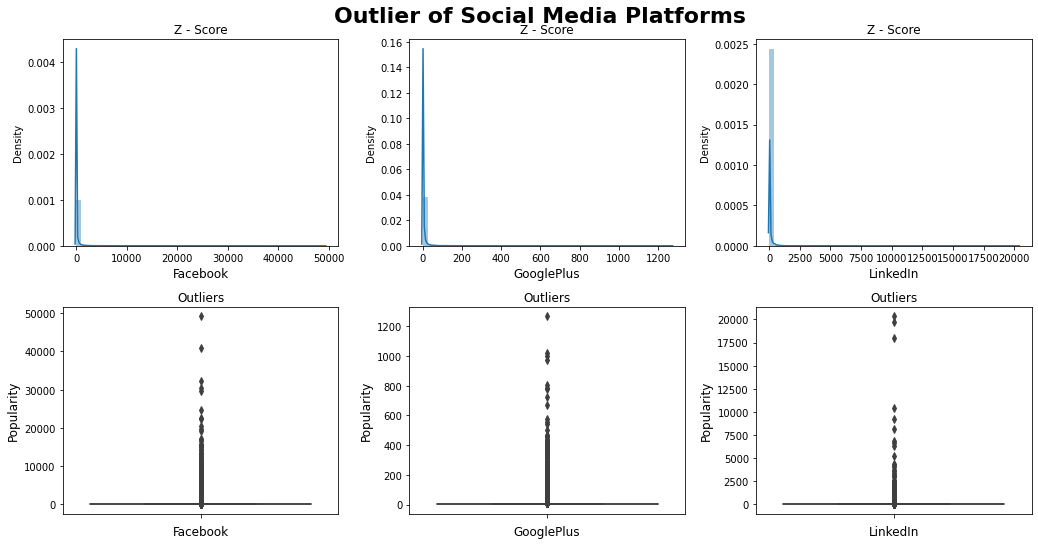

In [ ]:
def show_outliers(df, three_d = False):
    fig, axes = plt.subplots(2,3,figsize=(15, 8))
    fig.tight_layout(pad=4.0)
    for source in range(len(sources)):
        sns.distplot(ax=axes[0][source],x=df[sources[source]])
        axes[0][source].set_xlabel(sources[source],fontdict={'fontsize': 12})
        axes[1][source].set_ylabel('Density',fontdict={'fontsize': 12,})

        sns.boxplot(ax=axes[1][source],y=df[sources[source]] )    
        axes[1][source].set_xlabel(sources[source],fontdict={'fontsize': 12})
        axes[1][source].set_ylabel('Popularity',fontdict={'fontsize': 12})

        axes[0][source].set_title('Z - Score')
        axes[1][source].set_title('Outliers')

        plt.suptitle('Outlier of Social Media Platforms',fontsize = 22,fontweight = 'bold')

    plt.show()
    
    if three_d == True:
        fig = px.scatter_3d(df, x='Facebook', y='GooglePlus', z='LinkedIn', title='Dependent Variables')
        fig.show()

    # fig = go.Figure(data=[go.Surface(z=df[['Facebook','LinkedIn','GooglePlus']].values)])

    # fig.update_layout(title='abc', autosize=True)

    # fig.show()

show_outliers(master_df, True)

- The Density Plot clearly shows the data is Positively Skewed.
- We can observe outliers with the help of Box and Whisker plot.
- From the 3-D plot, we can clearly see how dependent features are distributed.
- Since, our data consists of outliers, let's start with handling them.

### **Outlier Treatment**
---
We have used the ***Quantile Method*** to treat outliers along with the 90 percentile method.

In [ ]:
# print(tenth_percentile, ninetieth_percentile)
# print("old array:",max(master_df[source]))
# print("old array:",max(df[source]))


# Computing 10th, 90th percentiles and treating the outliers
def outliers_treatment(df, sources):
    for source in sources:
        # tenth_percentile = np.percentile(df[source], 10)
        ninetieth_percentile = np.percentile(df[source], 90)
        # df[source] = np.where(df[source] < tenth_percentile, tenth_percentile, df[source])
        df[source] = np.where(df[source] > ninetieth_percentile, ninetieth_percentile, df[source])

    return df

master_df = outliers_treatment(master_df, sources)

### **Data representation after outlier treatment.**
---
- Density graphs display data as bi-modal rather than the previous positive skew.
- Box plot display that we have still got a few outliers but we consider working with them.

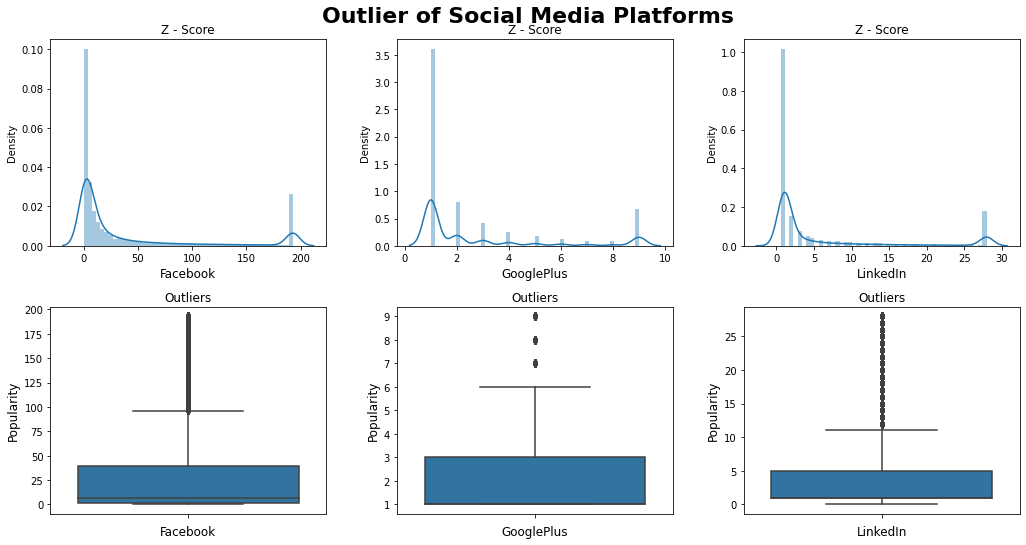

In [ ]:
show_outliers(master_df, True)

The 3D plot shows the distribution of dependent features after outlier treatment. It look like a box, due to large number of data points, but actually its not. If you want to see the data points then you need to zoom in the plot. 

### **Standard Scaler Implementation**
---
Below we apply StandardScaler to standardize data after outlier treatment

In [ ]:
#Standardize data
scaler = StandardScaler()

for source in sources:
    master = master_df[source].apply(lambda x:x if x!=(0) else np.nan)
    master_df[f'{source}_scaled'] = scaler.fit_transform(master.values.reshape(-1,1))

    master_df[f'{source}_scaled'].fillna(0,inplace=True)
    master_df[source].fillna(0,inplace=True)

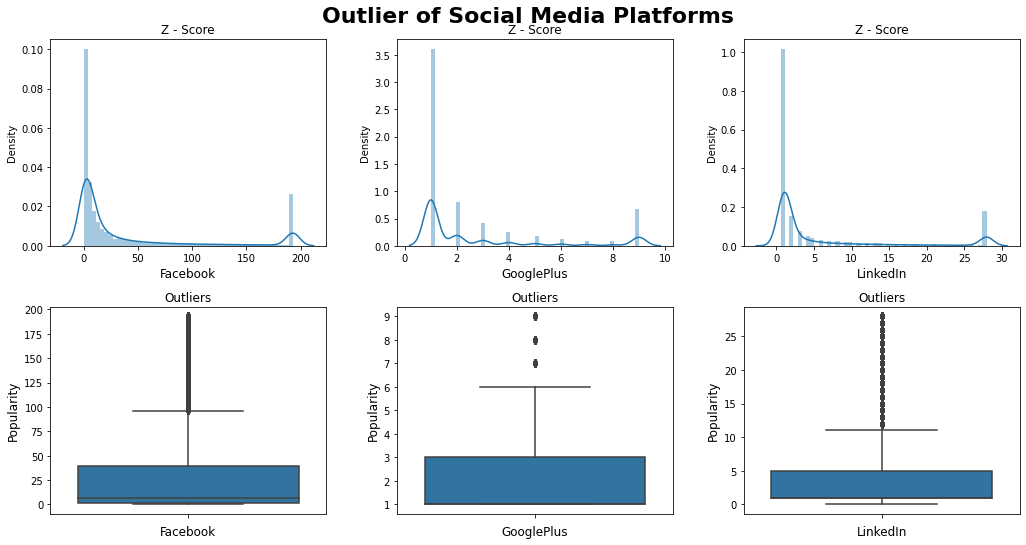

In [ ]:
show_outliers(master_df)

*Now our dependent features are scaled..!*

In [ ]:
master_df.reset_index(inplace=True, drop=True)
master_df.head(2)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,PublishTime,Weekday,Facebook_scaled,GooglePlus_scaled,LinkedIn_scaled
0,80690.0,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",Bloomberg,palestine,2016-02-28,0.0,-0.005906,1.0,1.0,1.0,14:03:00,Sunday,-0.633726,-0.617774,-0.549169
1,81052.0,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",Bloomberg,palestine,2016-03-01,0.0,0.048546,1.0,1.0,1.0,09:29:00,Tuesday,-0.633726,-0.617774,-0.549169


# **Exploratory Data Analysis**
---

## **Categorizing SentimentTitle and SentimentHeadline**
We have categoried the sentiment title and sentiment headline into three different categories based on their sentiment scores:
- Positive
- Negative
- Neutral

In [ ]:
master_df['SentimentTitle_Category'] = master_df['SentimentTitle'].apply(lambda x: 'neutral' if x == 0 else 'positive' if x > 0 else 'negative')

master_df['SentimentHeadline_Category'] = master_df['SentimentHeadline'].apply(lambda x: 'neutral' if x == 0 else 'positive' if x > 0 else 'negative')
master_df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,PublishTime,Weekday,Facebook_scaled,GooglePlus_scaled,LinkedIn_scaled,SentimentTitle_Category,SentimentHeadline_Category
0,80690.0,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",Bloomberg,palestine,2016-02-28,0.000000,-0.005906,1.0,1.0,1.0,14:03:00,Sunday,-0.633726,-0.617774,-0.549169,neutral,negative
1,81052.0,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",Bloomberg,palestine,2016-03-01,0.000000,0.048546,1.0,1.0,1.0,09:29:00,Tuesday,-0.633726,-0.617774,-0.549169,neutral,positive
2,80994.0,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",Bloomberg,palestine,2016-03-01,-0.243068,0.048546,1.0,1.0,1.0,00:15:00,Tuesday,-0.633726,-0.617774,-0.549169,negative,positive
3,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08,0.000000,-0.132812,1.0,1.0,1.0,05:25:00,Sunday,-0.633726,-0.617774,-0.549169,neutral,negative
4,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08,-0.082022,0.205537,1.0,1.0,1.0,05:40:00,Sunday,-0.633726,-0.617774,-0.549169,negative,positive


In [ ]:
def show_no_of_news_sentiment_title(df):
    print('******** No. of News items of SentimentTitle ********')
    print(df.SentimentTitle_Category.value_counts(),'\n')

    plt.figure(figsize=(10,8))
    df.SentimentTitle_Category.value_counts().plot(kind='bar')
    plt.title('News Items Distribution of Each Sentiment Title', fontdict={'size':20, 'fontweight' : 'bold'})
    plt.xlabel('Sentiment Type',fontdict={'size':15})
    plt.ylabel('No. of News Items',fontdict={'size':15})

def show_no_of_news_sentiment_headline(df):
    print('******** No. of News items of SentimentHeadline ********')
    print(df.SentimentHeadline_Category.value_counts(),'\n')

    plt.figure(figsize=(10,8))
    df.SentimentHeadline_Category.value_counts().plot(kind='bar')
    plt.title('News Items Distribution of Each Sentiment Headline', fontdict={'size':20, 'fontweight' : 'bold'})
    plt.xlabel('Sentiment Type',fontdict={'size':15})
    plt.ylabel('No. of News Items',fontdict={'size':15})


## **Sentiment Headline and Sentiment Title**
- Below two graphs depicts the count of news items falling in each sentiment category.
- We can clearly see that the neutral news items are less as compared to positive and negative news.
- We can also conclude that the number of negative sentiment news are higher as compared to positive ones.


******** No. of News items of SentimentTitle ********
negative    35484
positive    34377
neutral     17617
Name: SentimentTitle_Category, dtype: int64 



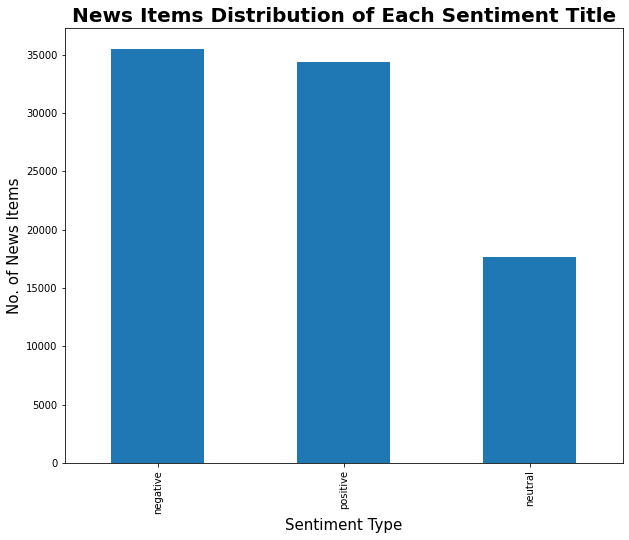

In [ ]:
show_no_of_news_sentiment_title(master_df)

******** No. of News items of SentimentHeadline ********
negative    49452
positive    35328
neutral      2698
Name: SentimentHeadline_Category, dtype: int64 



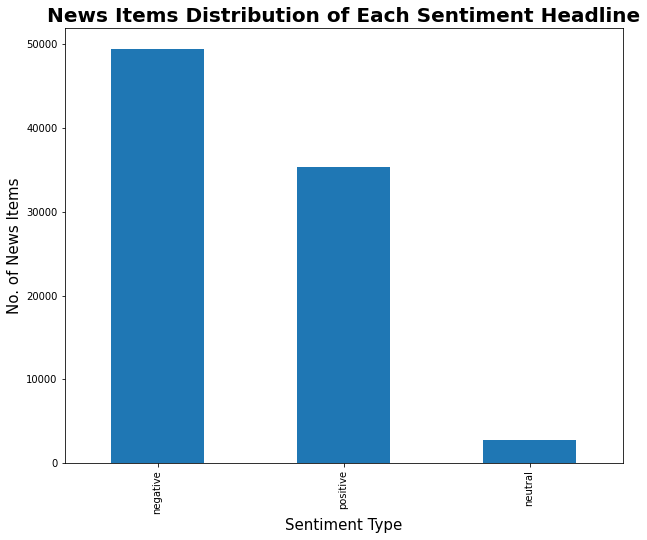

In [ ]:
show_no_of_news_sentiment_headline(master_df)

## **Categorizing Sources**
As we can see that we have so many news outlets, but we cannot work with such huge amount of varied data. So, we categoried the news outlets primarily into four main categories based on their number of news items published:
- Source A
- Source B
- Source C
- Source D

In [ ]:
# Categorizing Source Columns

# master_df['Source'].value_counts().unique()
# len(master_df['Source'].value_counts().unique())
# print(list(master_df['Source'].unique()))
# np.median(master_df['Source'].value_counts().unique())
# master_df.Source.value_counts().describe()
# plt.boxplot(master_df.Source.value_counts())
# master_df.Source.value_counts()
# source_df = pd.DataFrame(master_df['Source'].value_counts())
# len(source_df[source_df['Source']==1].index) # A
# len(source_df[source_df['Source']==2].index) #B
# len(source_df[(source_df['Source']>2) & (source_df['Source']<=8)].index) # C
# len(source_df[source_df['Source']>8].index) # D
# master_df.Topic.unique()
# master_df['Source_type'] = master_df['Source'].apply(lambda x : 'A' if source_df['Source'][x]==1 else ('B' if source_df['Source'][x]==2 else ('C' if (source_df['Source'][x] > 2 and source_df['Source'][x] <= 8) else x )))
# master_df[(master_df.Source_type != 'A') & (master_df.Source_type != 'B') & (master_df.Source_type != 'C') ].Source_type.value_counts().describe()

q1 = np.percentile(master_df['Source'].value_counts().unique(), 25, interpolation = 'midpoint')
q2 = np.percentile(master_df['Source'].value_counts().unique(), 50, interpolation = 'midpoint')
q3 = np.percentile(master_df['Source'].value_counts().unique(), 75, interpolation = 'midpoint')
print('----- Quaters -----')
print('> q1: ',q1,'\n> q2:',q2,'\n> q3:',q3)


source_df = pd.DataFrame(master_df['Source'].value_counts())
master_df['Source_type'] = master_df['Source'].apply(lambda x: 'A' if source_df['Source'][x]<=q1 else 'B' 
                                                     if source_df['Source'][x]<=q2 else 'C' if source_df['Source'][x]<=q3 else 'D')
master_df.drop(columns=['Source'], inplace = True)

----- Quaters -----
> q1:  56.5 
> q2: 123.5 
> q3: 263.5


## **News Items Distribution**
- Below plot clearly shows the distribution of news items published by each category of sources.
- Source A has published the highest, and Source B published the lowest number of news items respectively.

******** No. of News items in Sources ********
A    31847
D    28929
C    14637
B    12065
Name: Source_type, dtype: int64 



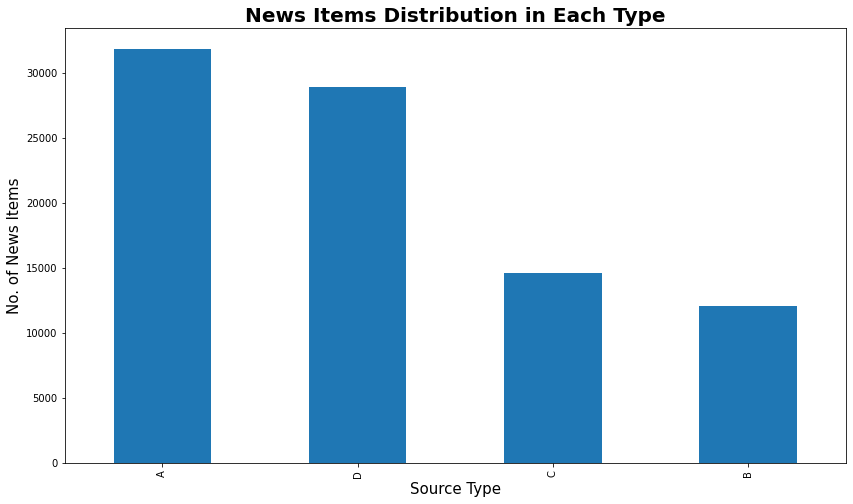

In [ ]:
def show_news_distribution_in_sources(df):
    print('******** No. of News items in Sources ********')
    print(df.Source_type.value_counts(),'\n')

    plt.figure(figsize=(14,8))
    df.Source_type.value_counts().plot(kind='bar')
    plt.title('News Items Distribution in Each Type', fontdict={'size':20,'fontweight' : 'bold'})
    plt.xlabel('Source Type',fontdict={'size':15})
    plt.ylabel('No. of News Items',fontdict={'size':15})

show_news_distribution_in_sources(master_df)

## **Popularity Comparison for Social Media Platforms**
- Below plot represents the popularity level of a particular news topic on different social media platform.
- From the below observations we can conclude on few points:
        1.   News item related to Obama are much more popular on Facebook as compared to other platforms.
        2.   Popularity level of Economy related news items and Obama related news items is approximately equal on GooglePlus.
        3.   Popularity level of Economy news is same on both Facebook and GooglePlus.
        4.   On LinkedIn, Microsoft related news gains higher popularity compared to others.
        5.   On LinkedIn, popularity of Economy news items is very less.



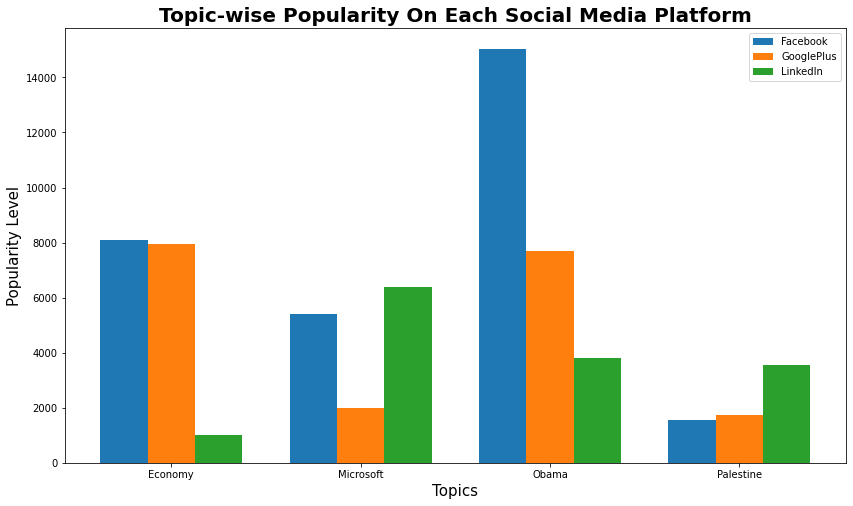

In [ ]:
def show_popularities(df):
    facebook = abs(df.groupby(['Topic'])['Facebook_scaled'].sum())
    googleplus = abs(df.groupby(['Topic'])['GooglePlus_scaled'].sum())
    linkedin = abs(df.groupby(['Topic'])['LinkedIn_scaled'].sum())

    ind = np.arange(len(topics)) 


    plt.figure(figsize=(14,8))
    plt.bar(ind-0.25,facebook,width=0.25,label='Facebook')
    plt.bar(ind,googleplus,width=0.25,label='GooglePlus')
    plt.bar(ind+0.25,linkedin,width=0.25,label='LinkedIn')

    plt.xticks(ind, topics)
    plt.legend()
    plt.title('Topic-wise Popularity On Each Social Media Platform', fontdict={'size':20, 'fontweight' : 'bold'})
    plt.xlabel('Topics', fontdict={'size':15})
    plt.ylabel('Popularity Level', fontdict={'size':15})
    plt.show()

show_popularities(master_df)

In [ ]:
# def show_correlation_plot_of_dependent_features(df):
#     temp_df = df.copy()
#     temp_df['Facebook'] = np.log10(df['Facebook'][df['Facebook']>0])
#     temp_df['GooglePlus'] = np.log10(df['GooglePlus'][df['GooglePlus']>0])
#     temp_df['LinkedIn'] = np.log10(df['LinkedIn'][df['LinkedIn']>0])

#     returns_fig = sns.PairGrid(temp_df[['Facebook','GooglePlus','LinkedIn']])

#     returns_fig.map_upper(sns.scatterplot, color="purple", alpha=0.3)
#     returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
#     returns_fig.map_diag(sns.histplot,bins=20,color=".3")
#     plt.title('Correlation Between Dependent Features', fontdict={'size':20})

# show_correlation_plot_of_dependent_features(master_df)

# from statistics import mode
# for col in df['Facebook_Economy'].loc[:,'TS1':].columns:
#     print(mode(df['Facebook_Economy'].loc[:,'TS1':][col]))
# for col in df['Facebook_Economy'].loc[:,'TS1':].columns:
#     print(np.mean(df['Facebook_Economy'].loc[:,'TS1':][col]))

In [ ]:
def mean_cal(data):
    count = len(data)-data.count(0)
    if count==0:
        return 0
    avg = (sum(data))/count

    return avg

rows = df['Facebook_Economy'].loc[:,'TS1':].columns

def mean_news_popularity(df_dict, social_media, rows):
    mean_df = pd.DataFrame(index = rows, columns = ['Economy','Microsoft','Obama','Palestine'])
    mean_df['Economy'] = df_dict[f'{social_media}_Economy'].apply(lambda x: mean_cal(list(x)))
    mean_df['Microsoft'] = df_dict[f'{social_media}_Microsoft'].apply(lambda x: mean_cal(list(x)))
    mean_df['Obama'] = df_dict[f'{social_media}_Obama'].apply(lambda x: mean_cal(list(x)))
    mean_df['Palestine'] = df_dict[f'{social_media}_Palestine'].apply(lambda x: mean_cal(list(x)))

    return mean_df

def show_news_popularity_with_time(df, Platform, rows):
    sns.set(rc={'figure.figsize':(25,7)})
    sns.lineplot(data = mean_news_popularity(df, Platform, rows), dashes=False)
    plt.title(f'News Popularity With Time On {Platform}',fontdict={'size':20, 'fontweight' : 'bold'})
    plt.xlabel('Time',fontdict={'size':15})
    plt.ylabel('Popularity',fontdict={'size':15})

def compare_news_popularity(df, Platform, rows):
    sns.set(rc={'figure.figsize':(10,7)})
    sns.barplot(data = mean_news_popularity(df, Platform, rows))
    plt.title(f'Popularity Comparison On {Platform}',fontdict={'size':20,'fontweight' : 'bold'})
    plt.xlabel('Topics',fontdict={'size':15})
    plt.ylabel('Popularity',fontdict={'size':15})

In [ ]:
def mean_suitable_platform(df_dict, topic, rows):
    mean_df = pd.DataFrame(index=rows, columns = ['LinkedIn','GooglePlus','Facebook'])
    mean_df['LinkedIn'] = df_dict[f'LinkedIn_{topic}'].apply(lambda x: mean_cal(list(x)))
    mean_df['GooglePlus'] = df_dict[f'GooglePlus_{topic}'].apply(lambda x: mean_cal(list(x)))
    mean_df['Facebook'] = df_dict[f'Facebook_{topic}'].apply(lambda x: mean_cal(list(x)))

    return mean_df

def show_best_platform_for_news(df_dict, topic, rows):
    sns.set(rc={'figure.figsize':(25,7)})
    sns.lineplot(data = mean_suitable_platform(df_dict, topic, rows), dashes=False)
    plt.title(f'Best Social Media for {topic}',fontdict={'size':20,'fontweight' : 'bold'})
    plt.xlabel('Time',fontdict={'size':15})
    plt.ylabel('Popularity',fontdict={'size':15})

def compare_platforms(df_dict, topic, rows):
    sns.set(rc={'figure.figsize':(10,7)})
    sns.barplot(data = mean_suitable_platform(df_dict, topic, rows))
    plt.title(f'Platform Comparison for {topic}',fontdict={'size':20,'fontweight' : 'bold'})
    plt.xlabel('Social Media',fontdict={'size':15})
    plt.ylabel('Popularity',fontdict={'size':15})


In [ ]:
def show_groupwise_popularity_distribution(df):
    temp_df = df.copy()
    temp_df['Facebook'] = np.log10(temp_df['Facebook'][temp_df['Facebook']>0])
    temp_df['GooglePlus'] = np.log10(temp_df['GooglePlus'][temp_df['GooglePlus']>0])
    temp_df['LinkedIn'] = np.log10(temp_df['LinkedIn'][temp_df['LinkedIn']>0])

    fig, axes = plt.subplots(2, 3, sharex=True, figsize=(20,10))
    fig.suptitle('Group-wise News Popularity Distribution', fontdict={'size':20, 'fontweight' : 'bold'})
    sns.scatterplot(ax = axes[0,0],x="Source_type",y="Facebook", data=temp_df,hue='Source_type')
    sns.scatterplot(ax = axes[0,1],x="Source_type",y="GooglePlus", data=temp_df,hue='Source_type')
    sns.scatterplot(ax = axes[0,2],x="Source_type",y="LinkedIn", data=temp_df, hue='Source_type')

    sns.boxplot(ax = axes[1,0],x="Source_type",y="Facebook", data=temp_df,hue='Source_type')
    sns.boxplot(ax = axes[1,1],x="Source_type",y="GooglePlus", data=temp_df,hue='Source_type')
    sns.boxplot(ax = axes[1,2],x="Source_type",y="LinkedIn", data=temp_df, hue='Source_type')

In [ ]:
def mean_source_popularity(df, df_dict, platform, rows):
    source_a_df, source_b_df, source_c_df, source_d_df = df[df['Source_type'] == 'A'],df[df['Source_type'] == 'B'],df[df['Source_type'] == 'C'],df[df['Source_type'] == 'D']
    
    platform_df = df_dict[f'{platform}_Economy'].append(df_dict[f'{platform}_Microsoft'].append(df_dict[f'{platform}_Obama'].append(df_dict[f'{platform}_Palestine'])))

    pt_sa = source_a_df.join(platform_df, on = 'IDLink',how = 'inner',lsuffix='l',rsuffix='r')
    pt_sb = source_b_df.join(platform_df, on = 'IDLink',how = 'inner',lsuffix='l',rsuffix='r')
    pt_sc = source_c_df.join(platform_df, on = 'IDLink',how = 'inner',lsuffix='l',rsuffix='r')
    pt_sd = source_d_df.join(platform_df, on = 'IDLink',how = 'inner',lsuffix='l',rsuffix='r')

    pt_sa = pt_sa.loc[:,'TS1':]
    pt_sb = pt_sb.loc[:,'TS1':]
    pt_sc = pt_sc.loc[:,'TS1':]
    pt_sd = pt_sd.loc[:,'TS1':]


    mean_df = pd.DataFrame(index=rows, columns = ['Source_A','Source_B','Source_C', 'Source_D'])
    mean_df.Source_A = pt_sa.apply(lambda x: mean_cal(list(x)))
    mean_df.Source_B = pt_sb.apply(lambda x: mean_cal(list(x)))
    mean_df.Source_C = pt_sc.apply(lambda x: mean_cal(list(x)))
    mean_df.Source_D = pt_sd.apply(lambda x: mean_cal(list(x)))

    return mean_df

def show_source_popularity_with_time(df, df_dict, platform, rows):
    sns.set(rc={'figure.figsize':(25,7)})
    sns.lineplot(data = mean_source_popularity(df, df_dict, platform, rows), dashes=False)
    plt.title(f'Source-wise Popularity on {platform}',fontdict={'size':20,'fontweight' : 'bold'})
    plt.xlabel('Time',fontdict={'size':15})
    plt.ylabel('Popularity',fontdict={'size':15})

def show_source_popularity_comparison(df, df_dict, platform, rows):

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,8))
    df1 = mean_source_popularity(df, df_dict, platform, rows)
    plt.suptitle(f'Popularity Comparison on {platform}',fontsize = 20,fontweight = 'bold')
    sns.barplot(ax = axes[0],data = df1)
    sns.boxenplot(ax = axes[1],data = df1)
    axes[0].set_ylabel('Popularity', fontsize = 15)
    axes[0].set_xlabel('Sources', fontsize = 15)
    axes[1].set_ylabel('Popularity', fontsize = 15)
    axes[1].set_xlabel('Sources', fontsize = 15)
    

In [ ]:
def seperate_news_for_topic(df):

    obama_news = df[df['Topic'] == 'obama']
    microsoft_news = df[df['Topic'] == 'microsoft']
    economy_news = df[df['Topic'] == 'economy']
    palestine_news = df[df['Topic'] == 'palestine']

    return (obama_news, microsoft_news, economy_news, palestine_news)

topic_tuple = seperate_news_for_topic(master_df)
obama_news = topic_tuple[0]
microsoft_news = topic_tuple[1]
economy_news = topic_tuple[2]
palestine_news = topic_tuple[3]

In [ ]:
def plot_news_vs_publish_date_month_wise(News_Final, sd, ed):
    startdate = pd.to_datetime(sd).date()
    enddate = pd.to_datetime(ed).date()
    news_final_new1 = News_Final[(News_Final['PublishDate']>=startdate) & (News_Final['PublishDate']<=enddate)] 
    group_news1 = news_final_new1.groupby('PublishDate' ).count()
    mean_group_news1  = news_final_new1.groupby('PublishDate').mean()

    ax = plt.figure(figsize=(18,7))
    plt.plot(group_news1.index, group_news1['SentimentHeadline'])
    plt.plot(mean_group_news1.index, (mean_group_news1['Facebook']), label='Facebook')
    plt.plot(mean_group_news1.index, (mean_group_news1['GooglePlus']), label='GooglePlus')
    plt.plot(mean_group_news1.index, (mean_group_news1['LinkedIn']), label='LinkedIn')
    plt.title('No. of News Items Publish Per Month',fontdict={'size':20, 'fontweight' : 'bold'})
    plt.xlabel('Published Date',fontdict={'size':15})
    plt.ylabel('Number of News',fontdict={'size':15})
    ax.legend(ncol=2, loc="lower right", frameon=True)


In [ ]:
def get_master_tsdf_min_after_pub(df, tsdf_name):
    # df['SOP'] = df.apply(lambda x:  sum([a for a in x[1:] if a>0]), axis = 1)

    social_med = tsdf_name.split('_')[0]
    columns_to_delete = df.columns[1:-1]
    tsdf_sum_fb = df.drop(columns=columns_to_delete)

    
    merge_master_tsdf_sum_fb = pd.merge(master_df[['IDLink','Topic','PublishDate', 'PublishTime', social_med]], tsdf_sum_fb, on ='IDLink')

    df['AppearedAfterMinutes'] = df.apply(lambda x:  sum([20 for a in x[1:] if a==0]), axis = 1)
    tsdf_map_fb = df.drop(columns=columns_to_delete)

    merge_master_tsdf_map_fb = pd.merge(master_df[['IDLink','Topic','PublishDate', 'PublishTime', social_med]], tsdf_map_fb, on ='IDLink')
    # merge_master_tsdf_map_fb = merge_master_tsdf_map_fb[merge_master_tsdf_map_fb[social_med] != -1]

    merge_master_tsdf_map_fb['PublishHour'] = merge_master_tsdf_map_fb['PublishTime'].apply(lambda x: str(x)[0:2])
    merge_master_tsdf_map_fb=merge_master_tsdf_map_fb.sort_values(by='PublishHour')
    return merge_master_tsdf_map_fb

def show_news_landed_on_platform_after_published(df_dict, Platform_Topic):
    platform_topic_list = Platform_Topic.split('_')
    merge_master_tsdf_map_fb = get_master_tsdf_min_after_pub(df[Platform_Topic], Platform_Topic)
    ax = plt.figure(figsize=(18,7))
    sns.lineplot(data=merge_master_tsdf_map_fb, x = 'PublishHour', y= 'AppearedAfterMinutes')
    plt.title(f'News First Appeared On {platform_topic_list[0]} of {platform_topic_list[1]} After Its Published',fontdict={'size':20,'fontweight' : 'bold'} )


In [ ]:
 group_obama = obama_news.groupby('PublishDate').count()
 group_microsoft = microsoft_news.groupby('PublishDate').count()
 group_economy = economy_news.groupby('PublishDate').count()
 group_palestine = palestine_news.groupby('PublishDate').count()

In [ ]:
def plot_topic_date_vs_news_count(df):
    group_news_count = df.groupby('PublishDate').count()
    ax = plt.figure(figsize=(18,7))
    plt.plot(group_news_count.index, group_news_count['SentimentHeadline'], label='All News')
    ax.legend(ncol=2, loc="upper right", frameon=True)
    plt.title('No. of News Items Published Per Day',fontdict={'size':20, 'fontweight' : 'bold'})
    plt.xlabel('Published Date',fontdict={'size':15})
    plt.ylabel('Number of News Published',fontdict={'size':15})

  

In [ ]:
def plot_topic_date_vs_news_items_published(group_obama, group_microsoft, group_economy, group_palestine):
    ax = plt.figure(figsize=(18,7))
    plt.plot(group_obama.index, group_obama['SentimentHeadline'], label='Obama')
    plt.plot(group_microsoft.index, group_microsoft['SentimentHeadline'], label='Microsoft')
    plt.plot(group_economy.index, group_economy['SentimentHeadline'] , label='Economy')
    plt.plot(group_palestine.index, group_palestine['SentimentHeadline'], label='Palestine')
    plt.title('No. of News Items Published Per Day on Various Topics',fontdict={'size':20, 'fontweight' : 'bold'})
    plt.xlabel('Published Date',fontdict={'size':15})
    plt.ylabel('Number of News Published',fontdict={'size':15})
    ax.legend()



In [ ]:
def plot_hour_vs_popularity(df, social_media):
  df['Hour'] = df['PublishTime'].apply(lambda x: str(x)[0:2])
  df=df.sort_values(by='Hour')
  ax = plt.figure(figsize=(18,7))
  sns.lineplot(data=df, y = social_media, x= 'Hour')
  plt.title(f'Popularity On {social_media} At Each Hour', fontdict={'fontsize': 22, 'fontweight' : 'bold'})
  plt.xlabel('Hour',fontsize = 15)
  plt.ylabel(f'{social_media}',fontsize = 15)

In [ ]:
def plot_sentiment_vs_news_count(palestine_news, obama_news, microsoft_news, economy_news, sentiment_type ):
  fig, axes = plt.subplots(2, 2, sharex=True,figsize=(20, 10))

  sns.histplot(ax= axes[0][0],data = palestine_news[sentiment_type], kde=True, color='green')
  axes[0][0].set_title('Palestine News',fontdict={'fontsize': '15', 'fontweight' : 'bold'})

  sns.histplot(ax= axes[0][1],data = obama_news[sentiment_type], kde=True, color='green')
  axes[0][1].set_title('Obama News',fontdict={'fontsize': '15', 'fontweight' : 'bold'})


  sns.histplot(ax= axes[1][0],data = microsoft_news[sentiment_type], kde=True, color='green')
  axes[1][0].set_title('Microsoft News',fontdict={'fontsize': '15', 'fontweight' : 'bold'})


  sns.histplot(ax= axes[1][1],data = economy_news[sentiment_type], kde=True, color='green')
  axes[1][1].set_title('Economy News',fontdict={'fontsize': '15', 'fontweight' : 'bold'})

  fig.suptitle('News Sentiment Density', fontsize = '22',fontweight = 'bold')


In [ ]:
def show_relation_between_sentiment_and_dependent_features(df, sentimentType, feature):
    df1 = df[['Facebook', 'GooglePlus','LinkedIn','Topic', 'SentimentTitle','SentimentHeadline']]
    # df1['Facebook'] = np.log10(df['Facebook'][df['Facebook']>0])
    # df1['GooglePlus'] = np.log10(df['GooglePlus'][df['GooglePlus']>0])
    # df1['LinkedIn'] = np.log10(df['LinkedIn'][df['LinkedIn']>0])

    fig = px.scatter(df1, x=sentimentType, y=feature, color="Topic", symbol="Topic", title=f'Popularity Based on {Sentiment_Type}')
    fig.show()

def show_sentiment_correlation(df):
    fig = px.scatter(df, x="SentimentTitle", y="SentimentHeadline", facet_col="Topic", title='Correlation Between Title Sentiment and Headline Sentiment',facet_row="Source_type", trendline="ols",trendline_color_override="red")
    fig.show()

def show_sentiment_heatmap(df):
    sns.heatmap(master_df[['SentimentHeadline','SentimentTitle','Facebook','GooglePlus','LinkedIn']].corr(),annot=True)
    plt.title('Sentiment HeatMap', fontdict={'size':20, 'fontweight' : 'bold'})

In [ ]:
 def senti_mean(df, df_dict, platform, rows):
    senti_p_df, senti_neu_df, senti_n_df = df[df['SentimentTitle_Category'] == 'positive'],df[df['SentimentTitle_Category'] == 'neutral'],df[df['SentimentTitle_Category'] == 'negative']
    platform_df = df_dict[f'{platform}_Economy'].append(df_dict[f'{platform}_Microsoft'].append(df_dict[f'{platform}_Obama'].append(df_dict[f'{platform}_Palestine'])))

    spos = senti_p_df.join(platform_df, on = 'IDLink',how = 'inner',lsuffix='l',rsuffix='r')
    sneu = senti_neu_df.join(platform_df, on = 'IDLink',how = 'inner',lsuffix='l',rsuffix='r')
    sneg = senti_n_df.join(platform_df, on = 'IDLink',how = 'inner',lsuffix='l',rsuffix='r')

    spos = spos.loc[:,'TS1':]
    sneu = sneu.loc[:,'TS1':]
    sneg = sneg.loc[:,'TS1':]


    senti_mean_df = pd.DataFrame(index=rows, columns = ['Positive','Neutral','Negative'])
    senti_mean_df.Positive = spos.apply(lambda x: mean_cal(list(x)))
    senti_mean_df.Neutral = sneu.apply(lambda x: mean_cal(list(x)))
    senti_mean_df.Negative = sneg.apply(lambda x: mean_cal(list(x)))

    return senti_mean_df

def show_sentiment_popularity_trend(df, df_dict, platform, rows):
    sns.set(rc={'figure.figsize':(25,7)})
    sns.lineplot(data = senti_mean(df, df_dict, platform, rows), dashes=False)
    plt.title(f'Sentiment-wise Popularity on {platform}',fontdict={'size':20, 'fontweight' : 'bold'})
    plt.xlabel('Time',fontdict={'size':15})
    plt.ylabel('Popularity',fontdict={'size':15})

def show_sentiment_popularity_comparison(df, df_dict, platform, rows):

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,8))
    df1 = senti_mean(df, df_dict, platform, rows)
    plt.suptitle(f'Popularity Comparison on {platform}',fontsize = 22, fontweight = 'bold')
    sns.barplot(ax = axes[0],data = df1)
    sns.boxenplot(ax = axes[1],data = df1)
    axes[0].set_ylabel('Popularity', fontsize = 15)
    axes[0].set_xlabel('Sentiment', fontsize = 15)
    axes[1].set_ylabel('Popularity', fontsize = 15)
    axes[1].set_xlabel('Sentiment', fontsize = 15)


In [ ]:
def show_popularities(df, sentiment):
    platform_df = df[['Facebook_scaled', 'GooglePlus_scaled','LinkedIn_scaled']]
    platform_df = abs(platform_df)
    platform_df[f'{sentiment}_Category'] = df[f'{sentiment}_Category']
    temp_df = pd.DataFrame(columns = ['Facebook','GooglePlus','LinkedIn'])
    temp_df['Facebook'] = platform_df.groupby([f'{sentiment}_Category'])['Facebook_scaled'].sum()
    temp_df['GooglePlus'] = platform_df.groupby([f'{sentiment}_Category'])['GooglePlus_scaled'].sum()
    temp_df['LinkedIn'] = platform_df.groupby([f'{sentiment}_Category'])['LinkedIn_scaled'].sum()
    
    
    bars=temp_df.columns

    fig = go.Figure(data=[
        go.Bar(name='Negative', x=bars, y=temp_df['Facebook']),
        go.Bar(name='Neutral', x=bars, y=temp_df['GooglePlus']),
        go.Bar(name='Positive', x=bars, y=temp_df['LinkedIn'])
    ])
    # Change the bar mode
    fig.update_layout(barmode='group',title_text='Sentiment Distribution')
    fig.show()
    # plt.title('Topic-wise Popularity On Each Social Media Platform', fontdict={'size':20})
    # plt.xlabel('Topics', fontdict={'size':15})
    # plt.ylabel('Popularity Level', fontdict={'size':15})
    # plt.show()



In [ ]:
def weekday_distribution(df):
    df1 = df[['Facebook','LinkedIn','GooglePlus','Weekday']]
    temp_df = pd.DataFrame([df1.groupby(['Weekday'])['Facebook'].mean(),df1.groupby(['Weekday'])['LinkedIn'].mean(),df1.groupby(['Weekday'])['GooglePlus'].mean()])

    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(25,7))
    fig.suptitle('Weekday Mean News Popularity Distribution', fontsize=22,fontweight='bold')
    temp_df.T['Facebook'].plot(ax = axes[0],kind='bar', color= 'grey', title='Facebook', ylabel='Popularity')
    temp_df.T['GooglePlus'].plot(ax = axes[1],kind='bar', color= 'lightgreen',title='GooglePlus',ylabel='Popularity')
    temp_df.T['LinkedIn'].plot(ax = axes[2],kind='bar', color= 'red', title='LinkedIn',ylabel='Popularity')
    axes[0].set_xlabel('Popularity', fontsize = 15)
    axes[0].set_ylabel('Weekday', fontsize = 15)
    axes[1].set_xlabel('Popularity', fontsize = 15)
    axes[1].set_ylabel('Weekday', fontsize = 15)
    axes[2].set_xlabel('Popularity', fontsize = 15)
    axes[2].set_ylabel('Weekday', fontsize = 15)

In [ ]:
def work_with_time_and_date(df):
    # Changing time in Seconds
    df['PublishTime'] = df.PublishTime.apply(lambda x: (x.hour * 60 + x.minute) * 60 + x.second)
    seconds_in_day = 24*60*60

    # Making Time Cyclic
    df['PublishSinTime'] = df['PublishTime'].apply(lambda x: np.sin(2*np.pi*x/seconds_in_day))
    df['PublishCosTime'] = df['PublishTime'].apply(lambda x: np.cos(2*np.pi*x/seconds_in_day))

    df.drop(columns='PublishTime',inplace=True)

    # Categorizing Months
    df['PublishMonth'] = master_df['PublishDate'].apply(lambda x: calendar.month_name[x.month])

    return df


In [ ]:
def show_month_distribution(df):
    fig, axes = plt.subplots(1, 3, figsize=(25,7))
    fig.suptitle('Month-wise News Popularity Distribution', fontsize=20, fontweight = 'bold')

    sns.barplot(ax = axes[0],x='PublishMonth',y='Facebook',data = master_df)
    sns.barplot(ax = axes[1],x='PublishMonth',y='GooglePlus',data = master_df)
    sns.barplot(ax = axes[2], x='PublishMonth',y='LinkedIn',data = master_df)
    
    for i in range(3):
        axes[i].tick_params(labelrotation=45)
        axes[i].set_ylabel('Popularity', fontsize = 15)

    axes[0].set_xlabel('Facebook', fontsize = 15)
    axes[1].set_xlabel('GooglePlus', fontsize = 15)
    axes[2].set_xlabel('LinkedIn', fontsize = 15)

In [ ]:
# Merge all the 12 Time Series Dataframe with master_df

def change_df(df, n, col_name_prefix):
    df['TS0'] = 0
    new_df = df[['IDLink']]
    for i,j in zip(range(1,(72//n)+1), range(n, 73, n)):
        new_df[f'{col_name_prefix}_t{i}'] = df[f'TS{j}'] - df[f'TS{j-n}']

    return new_df

def merge_df(fb_df, gp_df, li_df, topic):
    # Convert the dataframe into - "popularity in every 6 hours"
    # 3*k: 3 -> TS1+TS2+TS3 = 1 hour, k -> hours
    new_fb_df = change_df(fb_df, 3*6, 'fb')
    new_gp_df = change_df(gp_df, 3*6, 'gp')
    new_li_df = change_df(li_df, 3*6, 'li')

    new_final_df = new_fb_df.merge(new_gp_df.merge(new_li_df, on = 'IDLink', how='outer'), on = 'IDLink', how='outer')
    
    return new_final_df


def merge_all_df(master_df, df):
    
    # Step 1: Split master_df into Topics: Economy, Microsoft, Obama, Palestine
    economy_df, microsoft_df, obama_df, palestine_df = master_df[master_df.Topic == 'economy'], master_df[master_df.Topic == 'microsoft'], master_df[master_df.Topic == 'obama'], master_df[master_df.Topic == 'palestine']

    # Step 2: Combine all Topics dataframes: like: (Facebook_Economy, LinkedIn_Economy, GooglePlus_Economy), (Facebook_Obama, GooglePlus_Obama, LinkedIn_Obama), etc.
    
    df_time_dict = {}
    for topic in ['Economy','Microsoft','Obama','Palestine']:
        df_time_dict[topic] = merge_df(df[f'Facebook_{topic}'], df[f'GooglePlus_{topic}'], df[f'LinkedIn_{topic}'], topic )

    # Step 3: Merge splitted master_df dataframe and df_time_dict dataframes
    economy_df = economy_df.merge(df_time_dict['Economy'], on='IDLink',how = 'left')
    microsoft_df = microsoft_df.merge(df_time_dict['Microsoft'], on='IDLink',how = 'left')
    obama_df = obama_df.merge(df_time_dict['Obama'], on='IDLink',how = 'left')
    palestine_df = palestine_df.merge(df_time_dict['Palestine'], on='IDLink',how = 'left')


    # print(economy_df.shape, microsoft_df.shape, obama_df.shape, palestine_df.shape)
    
    # Step 4: Append all the dataframes to make the final master dataframe
    final_master_df = economy_df.append(microsoft_df.append(obama_df.append(palestine_df)))

    # Removing Null values
    print('Before: ',list(final_master_df.isna().sum()))

    # Checking for the news who has some popularity on any social media and it's time series columns are null
    temp = final_master_df[final_master_df.isnull().any(axis=1)]
    null_indexes = temp[temp['Facebook'] != 1].index
    for ind in null_indexes:
        final_master_df['fb_t1'][ind] = 1  # Popularity of those news after 2 days is 1. So, at some point in time, the popularity difference would be one.

    final_master_df.fillna(0, inplace=True)
    print('After: ',list(final_master_df.isna().sum()))

    return final_master_df



In [ ]:
def cols_to_remove(df):
    cols = []
    for col in df.columns:
        try:
            int(col)
            cols.append(col)
        except:
            continue

    return cols


def title_headline_processing():
    st = PorterStemmer()
    master_df['title_headline'] = master_df['Title']+', '+master_df['Headline']
    master_df['title_headline'] = master_df['title_headline'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    master_df['title_headline'] = master_df['title_headline'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words='english',max_df=0.7, min_df = 150, max_features = 1000)
    tfidf_wm = tfidfvectorizer.fit_transform(master_df['title_headline'])
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), columns=tfidf_tokens)
    df_tfidfvect['IDLink'] = master_df['IDLink'].reset_index(drop=True).copy()

    trash_cols = cols_to_remove(df_tfidfvect)

    # Removing all the numeric columns
    df_tfidfvect.drop(columns=trash_cols, inplace=True)

    return df_tfidfvect


In [ ]:
# def text_process(msg):
#     nopunc = [c for c in msg if c not in string.punctuation]
#     nopunc = ''.join(nopunc)
#     return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

# def add_doc_length():
#     word_len_df = master_df[['Title','Headline','Facebook','GooglePlus','LinkedIn']]
#     word_len_df

#     word_len_df['Title'] = word_len_df['Title'].apply(text_process)
#     word_len_df['Headline'] = word_len_df['Headline'].apply(text_process)

#     master_df['Title_wl'] = word_len_df.Title.apply(lambda x: len(x.split()))
#     master_df['Headline_wl'] = word_len_df.Headline.apply(lambda x: len(x.split()))

def add_doc_length():
    countVecorizer = CountVectorizer(analyzer = 'word', stop_words = 'english', max_df=0.7, min_df = 150)
    count_wm_title = countVecorizer.fit_transform(master_df['Title'])
    
    count_tokens_title = countVecorizer.get_feature_names()
    df1 = pd.DataFrame(data = count_wm_title.toarray(),columns = count_tokens_title)

    count_wm_headline = countVecorizer.fit_transform(master_df['Headline'])
    count_tokens_headline = countVecorizer.get_feature_names()
    df2 = pd.DataFrame(data = count_wm_headline.toarray(),columns = count_tokens_headline)
    master_df['Title_wl'] = df1.sum(axis = 1)
    master_df['Headline_wl'] = df2.sum(axis = 1)

def show_doc_length_desity_plot(df):
    fig, axes = plt.subplots(1, 2, figsize=(25,7))
    
    sns.distplot(df['Title_wl'], ax= axes[0], color='brown')
    axes[0].set_title('Title',fontdict={'fontsize': '15', 'fontweight' : 'bold'})
    axes[0].set_xlabel('Title Word Length', fontsize = 15)
    axes[0].set_ylabel('Density', fontsize = 15)

    sns.distplot(df['Headline_wl'],ax= axes[1], color='black')
    axes[1].set_title('Headline',fontdict={'fontsize': '15', 'fontweight' : 'bold'})
    axes[1].set_xlabel('Headline Word Length', fontsize = 15)
    axes[1].set_ylabel('Density', fontsize = 15)

    fig.suptitle('Title And Headline Document Length Distribution', fontsize = 22, fontweight = 'bold')


In [ ]:
def show_doc_length_relation_with_popularity(df):
    fig, axes = plt.subplots(3, 2, figsize=(25,25))
    
    sns.scatterplot(ax= axes[0][0],data = df, x = 'Title_wl', y='Facebook_scaled', color='green')
    axes[0][0].set_title('Title on Facebook',fontdict={'fontsize': '18', 'fontweight' : 'bold'})

    sns.scatterplot(ax= axes[0][1],data = df, x = 'Headline_wl', y='Facebook_scaled', color='green')
    axes[0][1].set_title('Headline on Facebook',fontdict={'fontsize': '18', 'fontweight' : 'bold'})


    sns.scatterplot(ax= axes[1][0],data = df, x = 'Title_wl', y='GooglePlus_scaled', color='red')
    axes[1][0].set_title('Title on GooglePlus',fontdict={'fontsize': '18', 'fontweight' : 'bold'})


    sns.scatterplot(ax= axes[1][1],data = df, x = 'Headline_wl', y='GooglePlus_scaled', color='red')
    axes[1][1].set_title('Headline on GooglePlus',fontdict={'fontsize': '18', 'fontweight' : 'bold'})

    
    sns.scatterplot(ax= axes[2][0],data = df, x = 'Title_wl', y='LinkedIn_scaled', color='blue')
    axes[2][0].set_title('Title on LinkedIn',fontdict={'fontsize': '18', 'fontweight' : 'bold'})

    sns.scatterplot(ax= axes[2][1],data = df, x = 'Headline_wl', y='LinkedIn_scaled', color='blue')
    axes[2][1].set_title('Headline on LinkedIn',fontdict={'fontsize': '18', 'fontweight' : 'bold'})

    fig.suptitle('Effect Of Title And Headline Length On Popularity', fontsize = 22, fontweight = 'bold')

    for i in range(0,3):
        for j in range(0,2):
            if j==1:
                axes[i][j].set_xlabel('Headline Word Length', fontsize = 15)
            else:
                axes[i][j].set_xlabel('Title Word Length', fontsize = 15)
            axes[i][j].set_ylabel('Density', fontsize = 15)


## **News Popularity Over The Time Period**
---
Here, we can see the trend of rise in popularity of different Topics on a particular social media platform.

### **Select a Social Media Platform**


In [ ]:
Platform = "GooglePlus" #@param ["Select Social Media", "Facebook", "GooglePlus", "LinkedIn"]

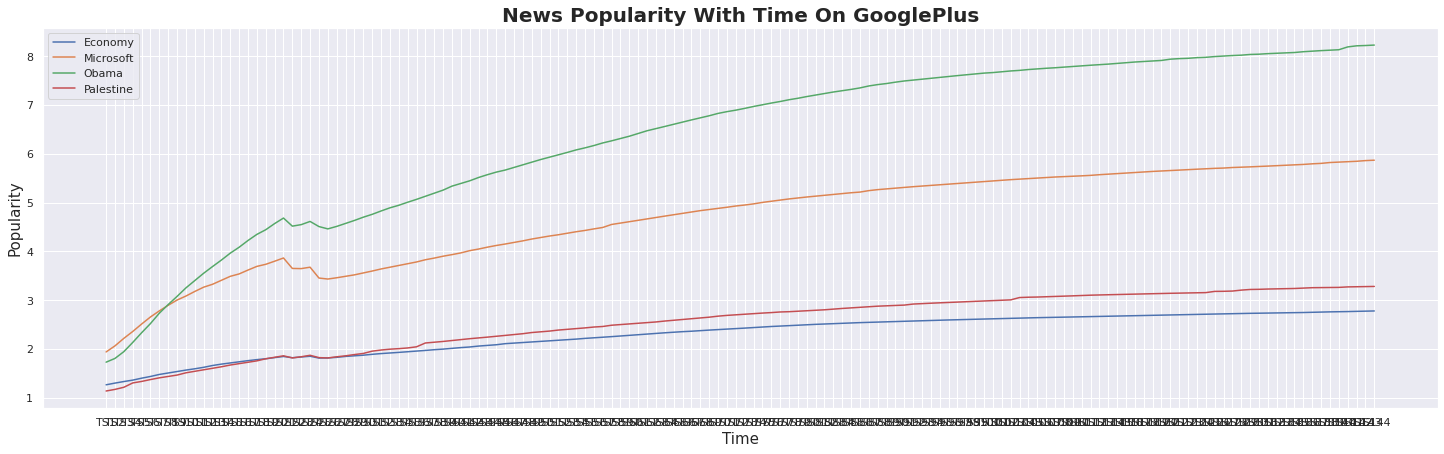

In [ ]:
show_news_popularity_with_time(df, Platform, rows)

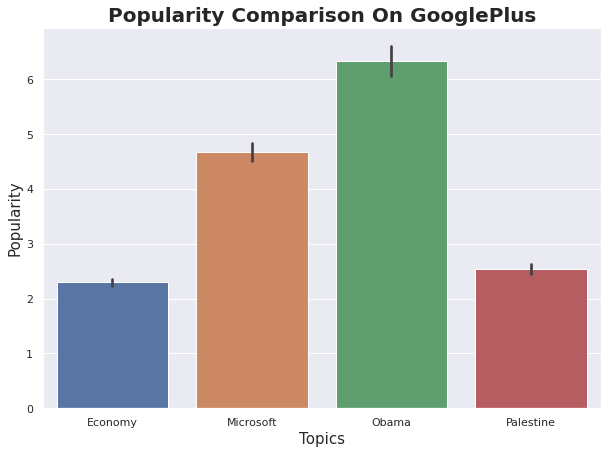

In [ ]:
compare_news_popularity(df, Platform, rows)

1. Supposedly the platform is GooglePlus, then we can say that the popularity trend of Economy is always below the popularity level of other topics over the time period.
2. Similarly, popularity of Obama news increases substantially over the period of time.

## **Best Social Media for Topics**
---
By looking into the below graph you can potentially identify the platform that will provide the higher popularity for a news item of a particular topic.

### **Select the Topic**

In [ ]:
Topic = "Economy" #@param ["Select Social Media", "Economy", "Microsoft", "Obama","Palestine"]

In [ ]:
show_best_platform_for_news(df, Topic, rows)

In [ ]:
compare_platforms(df, Topic, rows)

As we can see, the Facebook is the better platform for gaining higher popularity for news items related to Economy.

## **Source-wise Popularity On Social Media**
---
Here, we can see the most favourable social media platform for sources of a particular category.

### **Select a Platform**

In [ ]:
Platform = "Facebook" #@param ["Select Social Media", "Facebook", "GooglePlus", "LinkedIn"]

In [ ]:
show_source_popularity_with_time(master_df, df, Platform, rows)

In [ ]:
show_source_popularity_comparison(master_df, df, Platform, rows)

> - We can see the different popularity trend line of sources on a selected platform.
> - From Boxen Plots, we can see the range in which popularity lies for news items on a particular platform and their outliers.
> - Bar graph compares the popularity of different sources on a selected platform.

## **Popularity Distribution**
---
From the below plots, we can observe the popularity level of news published by different source types on a particular social media platform.

In [ ]:
show_groupwise_popularity_distribution(master_df)

> From above observations, we can conclude that some of the news items published from a particular source type, occationally gain a much more higher popularity on the social media platforms, compared to the other news items published by such source types.

## **News Publications Per Day**
---
From the below plot, we can conclude that the number of news published over the period of 8 months is evenly distributed.

In [ ]:
plot_topic_date_vs_news_count(master_df)

## **News Published Per Day On Various Topics**
---
Below graph shows the number of news items published on various topics of a period of 8 months.

In [ ]:
plot_topic_date_vs_news_items_published(group_obama, group_microsoft, group_economy, group_palestine)

> From the above graph, we can conclude that number of news items published of Palestine is less as compared to other news items belonging to other topics.

## **News Items Published in a Month**
---
Here, you just need to select the date range, and it will show you the news items published in month.

### **Select Start and End Date**

In [ ]:
Start_Date = '2015-12-12' #@param {type:"date"}
End_Date = '2016-02-12' #@param {type:"date"}

In [ ]:
# show_source_popularity_comparison(master_df, df, Platform, rows)
# plot_topic_date_vs_news_count(master_df)
# plot_topic_date_vs_news_count(group_obama, group_microsoft, group_economy, group_palestine)
plot_news_vs_publish_date_month_wise(master_df, str(Start_Date),str(End_Date))

- 

> From the above plot we can depict that the number of news items published expriences a drastic fall on every week-end.

## **First Apperance of News Items Upon Publication**
---
Here, you need to select a platform with topic option from the drop-down menu and the function will return you the effect of news published at a particular hour.

### **Select Platform_Topic:**

In [ ]:
Platform_Topic = "LinkedIn_Economy" #@param ["Select Social Media", "Facebook_Economy","Facebook_Microsoft","Facebook_Obama","Facebook_Palestine","GooglePlus_Economy","GooglePlus_Microsoft","GooglePlus_Obama","GooglePlus_Palestine","LinkedIn_Economy","LinkedIn_Microsoft","LinkedIn_Obama","LinkedIn_Palestine"]

In [ ]:
# show_groupwise_popularity_distribution(master_df)
# show_source_popularity_comparison(master_df, df, Platform, rows)
# plot_topic_date_vs_news_count(master_df)
# plot_topic_date_vs_news_count(group_obama, group_microsoft, group_economy, group_palestine)
# plot_news_vs_publish_date_month_wise(master_df, str(Start_Date),str(End_Date))
show_news_landed_on_platform_after_published(df, Platform_Topic)

> From the above graph we can conclude that the news published between 01:00 and 06:00 takes longer time to land on the LinkedIn platform.

## **Popularity Trend On Social Media At Every Hour**
---
From the below graph, you can see the popularity trend at every hour on a particular platform.

### **Select Platform:**

In [ ]:
Platform = "Facebook" #@param ["Select Social Media", "Facebook", "GooglePlus", "LinkedIn"]

In [ ]:
plot_hour_vs_popularity(master_df,Platform)

> - We can conclude that the popularity of almost every news item rises from 14:00 till mid-night.
> - And drastically decreases thereafter.

## **Topic-wise News Sentiment Density**
---
Below plots shows the density of the Sentiment score of various topics.

### **Select Sentiment Type:**

In [ ]:
Sentiment_Type = "SentimentTitle" #@param ["Select Type", "SentimentHeadline", "SentimentTitle"]


In [ ]:
plot_sentiment_vs_news_count(palestine_news, obama_news, microsoft_news, economy_news, Sentiment_Type )

## **Topic-wise Popularity Based on Sentiment Type**
---
These scattered plots shows the relation between sentiment scores and popularity level on social media.

In [ ]:
Sentiment_Type = "SentimentHeadline" #@param ["Select Type", "SentimentHeadline", "SentimentTitle"]
Platform = "LinkedIn" #@param ["Select Social Media", "Facebook", "GooglePlus", "LinkedIn"]

In [ ]:
show_relation_between_sentiment_and_dependent_features(master_df, Sentiment_Type, Platform)

## **Correlation between SentimentTitle, SentimentHeadline, SourceType and Topics**
---


In [ ]:
show_sentiment_correlation(master_df)

> - From above plots, we can conclude that there is no correlation between SentimentTitle, SourceType, SentimentHeadline and Topic.

## **Correlation Heatmap**
---

In [ ]:
show_sentiment_heatmap(master_df)

> - We can see that the correlation between dependent features is very near about 0.4-0.6, which shows that there is no collinearity between dependent features.
> - There is also no collinearity between independent features as well.

## **Sentiment Popularity On a Platform**
---
This graph depicts the change in popularity with time based on sentiment type.

### **Select Platform:**

In [ ]:
Platform = "Facebook" #@param ["Select Social Media", "Facebook", "GooglePlus", "LinkedIn"]

In [ ]:
show_sentiment_popularity_trend(master_df, df, Platform, rows )

In [ ]:
show_sentiment_popularity_comparison(master_df, df, Platform, rows)

> - From the above graphs we can conclude that the popularity of neutral sentiment items always remains below the popularity of positive and negative sentiment items.
> - Boxen plot shows the popularity outliers based on their sentiment.

## **Sentiment Distribution**
---
Here, below plot shows the sentiment wise distribution on Social Media Platform.

### **Select Sentiment Type:**

In [ ]:
Sentiment_Type = "SentimentTitle" #@param ["Select Type", "SentimentHeadline", "SentimentTitle"]

In [ ]:
show_popularities(master_df, Sentiment_Type)

> From this graph we can conclude that the neutral sentiment news items are comparatively published more on every social media platform.


## **Popularity Based on Published Weekday**
---
These plots depicts the popularity distribution on day to day basis.

In [ ]:
weekday_distribution(master_df)

> - Saturdays are good for Facebook and GooglePlus but bad for LinkedIn in terms of popularity.
> - Mondays are good for LinkedIn but bad for Facebook.

## **Working with Time**
---
- We all know that time is a cyclic quantity. So, we cannot directly plot X v/s Y plot for time because we will not be able to identify the correct distance between two time instances of a linear plot. 

- To make model understand the time as a cyclic quantity, we can convert the time into ***sin*** and ***cos*** value and can represent the time in **sin v/s cos** graph as depicted below to get a cyclic curve.

In [ ]:
master_df = work_with_time_and_date(master_df.copy())

def show_time(df):
    # Cyclic Time
    df[['PublishSinTime','PublishCosTime']].sample(100).plot.scatter('PublishSinTime','PublishCosTime', c='blue').set_aspect('equal')
    plt.xlabel('PublishSinTime',fontsize = 15)
    plt.ylabel('PublishCosTime',fontsize = 15)
    plt.title('Clock',fontdict={'fontsize': 22, 'fontweight' : 'bold'})

show_time(master_df)

## **Month-wise News Popularity Distribution**
---
This graph shows the popularity distribution of news items published every month.

In [ ]:
show_month_distribution(master_df)

> - From the above graph we can depict that the popularity level of news items in the month of July is quite less on Facebook compared to the other platforms.
> - There is not much difference in popularity levels of GooglePlus and LinkedIn in the span of 8 months.

## **Title and Headline Length Distribution**
---
- We also have textual data to deal with. We cannot directly give these columns to the model. So, we need to preprocess this text data.
- We have applied **TF-IDF Vectorization** method for text preprocessing.
- We merged the Title and Headline text data together. Applied Stemming and Lemmatization to normalize the data.

 > **Stemming:** Stemming is used to remove any kind of suffix from the word and return the word in its original form that is the root word but sometimes the root word that is generated is a non-meaningful word or it does not belong to the English dictionary.

 > **Lemmatization:** Lemmatization is similar to stemming but it works with much better efficiency. In lemmatization, the word that is generated after chopping off the suffix is always meaningful and belongs to the dictionary that means it does not produce any incorrect word. The word generated after lemmatization is also called a lemma.

- Parameters of TF-IDF Vecotrizer:
    > **Analyzer:** word
    
    > **Stop_words:** english
    
    > **Max_df:** 0.7
    
    > **Min_df:** 150

    > **Max_features:** 1000

- We also used **CountVectorizer** method to calculate the word length in a sentence.

- Below graphs shows the density of words of different length taken cummulatively from the title and headline of news items. 

Before:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5317, 5317, 5317, 5317, 0, 0, 0, 0, 0, 0, 0, 0]
After:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


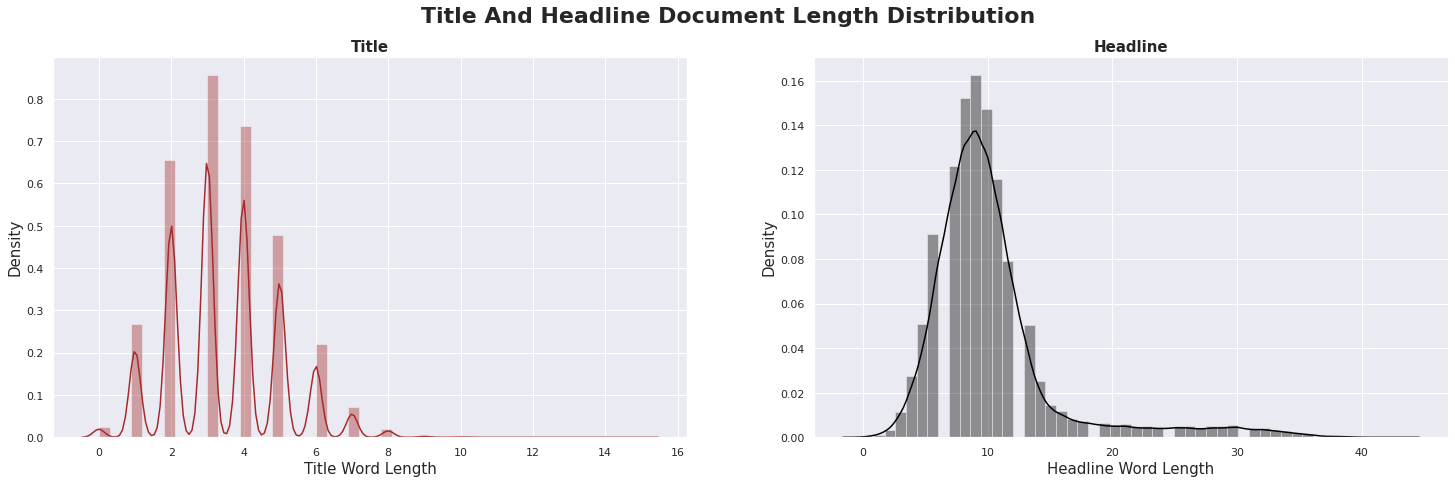

In [ ]:
#______
master_df = merge_all_df(master_df.copy(), df.copy())
tfidfvect_df = title_headline_processing()

#______
add_doc_length()
show_doc_length_desity_plot(master_df) 

> - In title, we did not see any significant pattern in the word length for different news items.
> - Whereas in Headline, we can see sentences ranging from 3 - 20 words have higher chance of occurance.

## **Effect Of Title and Headline Length On Popularity**
---
These plots shows the effect of title and headline length on popularity.

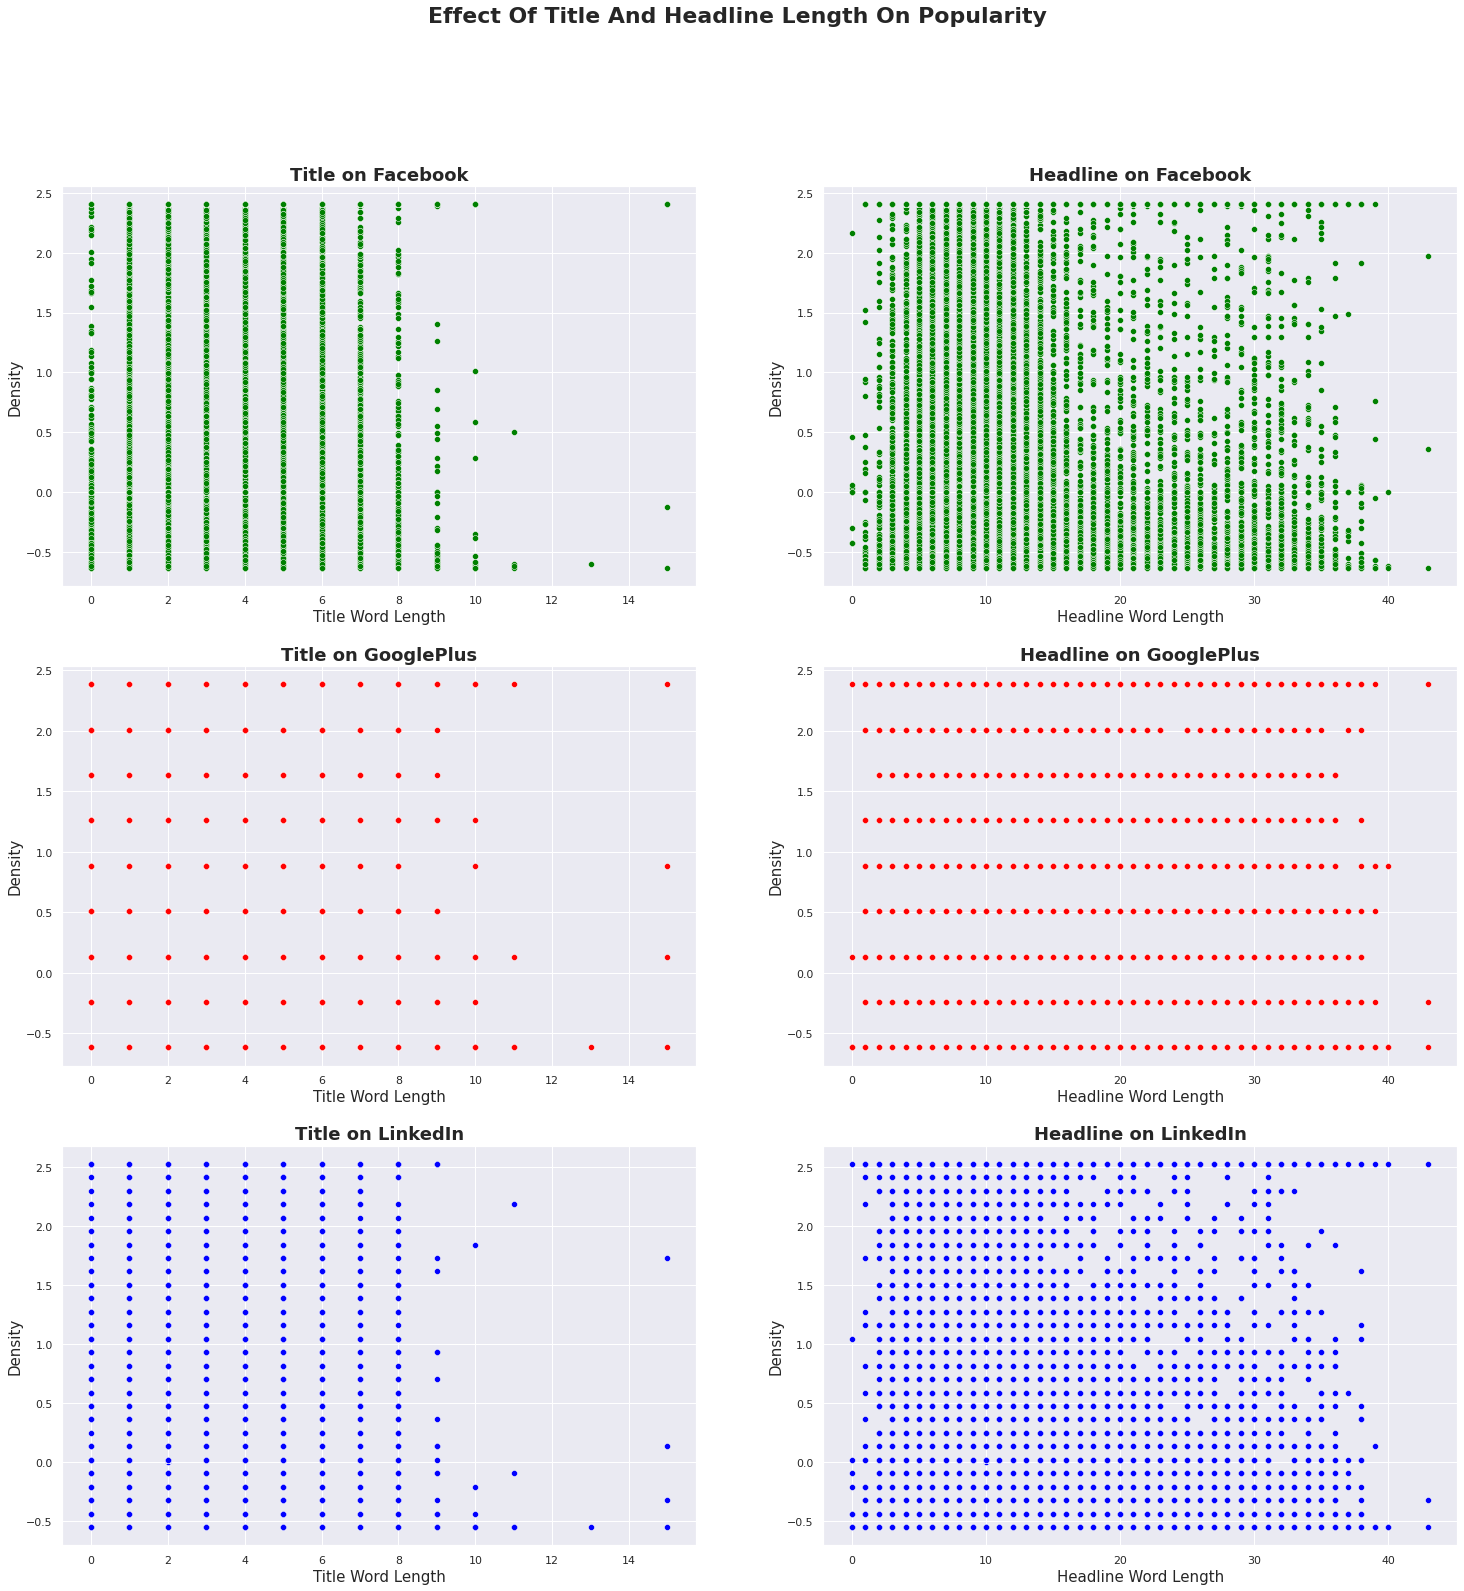

In [ ]:
show_doc_length_relation_with_popularity(master_df)

> - The scatter plots showed above does not gives much information.
> - Just one thing can be concluded from these plots, i.e. there is a possibility of not getting news item popular due to increase in length of title or headline.

## **Final Dataset**
---
* Title and Headline word length columns contains continuous values in our dataset. We scaled these columns.
* We also worked with text data. Its time merge textual data and our master dataframe.
* Let's drop all the irrelevant features left in our dataset.
* We also have some categorical features in our dataset. Let's **one-hot encode** them.

In [ ]:
# irrelevant_columns = ['IDLink', 'Title', 'Headline', 'PublishDate', 'Facebook', 
#                       'GooglePlus', 'LinkedIn', 'SentimentTitle_Category',
#                       'SentimentHeadline_Category','Hour','title_headline']
# ---------------------------------------------------------------------------------------------

# Scaling Title_wl and Headline_wl
master_df['Title_wl'] = scaler.fit_transform(master_df.Title_wl.values.reshape(-1,1))
master_df['Headline_wl'] = scaler.fit_transform(master_df.Headline_wl.values.reshape(-1,1))


# Merging TfidfVectorized dataframe and master_df
master_df = master_df.merge(tfidfvect_df, on='IDLink', how = 'left')


# Dropping irrelevant columns, i.e. other than 
irrelevant_columns = ['IDLink', 'Title', 'Headline', 'PublishDate', 'Facebook',
                      'SentimentTitle','SentimentHeadline', 'GooglePlus', 
                      'LinkedIn', 'Hour','title_headline']
master_df.drop(columns = irrelevant_columns, inplace = True)

master_df = pd.get_dummies(master_df, columns=['Topic','SentimentTitle_Category','SentimentHeadline_Category','Source_type','PublishMonth','Weekday'])

print(master_df.shape)
master_df.head()

(87478, 1023)


,Facebook_scaled,GooglePlus_scaled,LinkedIn_scaled,PublishSinTime,PublishCosTime,fb_t1,fb_t2,fb_t3,fb_t4,gp_t1,gp_t2,gp_t3,gp_t4,li_t1,li_t2,li_t3,li_t4,Title_wl,Headline_wl,abe,abl,access,accord,account,accus,acquir,act,action,activ,actual,ad,add,addit,address,administr,administration,advanc,advis,affect,africa,...,worri,worst,xbox,year,years,yellen,yesterday,york,young,zika,Topic_economy,Topic_microsoft,Topic_obama,Topic_palestine,SentimentTitle_Category_negative,SentimentTitle_Category_neutral,SentimentTitle_Category_positive,SentimentHeadline_Category_negative,SentimentHeadline_Category_neutral,SentimentHeadline_Category_positive,Source_type_A,Source_type_B,Source_type_C,Source_type_D,PublishMonth_April,PublishMonth_December,PublishMonth_February,PublishMonth_January,PublishMonth_July,PublishMonth_June,PublishMonth_March,PublishMonth_May,PublishMonth_November,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,-0.633726,-0.617774,-0.549169,0.996195,0.087156,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,-0.952021,3.524758,0.0,0.0,0.0,0.000000,0.198001,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,-0.633726,-0.617774,-0.549169,0.998630,0.052336,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,-0.952021,1.450363,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,-0.617904,-0.617774,-0.549169,0.782608,-0.622515,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,-1.608884,2.770433,0.0,0.0,0.0,0.157242,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,-0.174910,-0.617774,-0.549169,0.659346,-0.751840,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,-0.295159,0.507457,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.276477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,-0.602083,-0.617774,-0.207115,-0.233445,-0.972370,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,-1.608884,0.696038,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


- This is our final dataset of 87478 rows and 1023 columns.
> Hurry...! Here we are done with our Exploratory Data Analysis. Now, we have a clean and structured dataset in the desired format for better decision-making in less time.

*After EDA, its time to select important features for our machine learning models.*

# **Feature Selection**
---

In [ ]:
# Fetching Numerical Features and Dependent Features

def split_data(df, social_media):
    x1 = df[['PublishSinTime','PublishCosTime','Title_wl','Headline_wl']]
    x2 = df.loc[:,'fb_t1':'li_t4']

    for col in x2:
        x1[col] = x2[col]

    y1 = df[f'{social_media}_scaled']

    # Train-Test Split for each dependent feature
    x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state=23)

    return x1_train, y1_train

In [ ]:
def show_feature_importance(df):
    x, y = split_data(df, 'Facebook')
    model = ExtraTreesRegressor()
    model.fit(x,y)
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)

    feat_importances.nlargest(17).plot(kind='bar')
    plt.xlabel('Features', fontdict = {'fontsize':15})
    plt.ylabel('Importance', fontdict = {'fontsize':15})
    plt.title('Feature Importance',fontdict = {'fontsize':22, 'fontweight':'bold'})
    plt.show()



In [ ]:
def show_correlation_between_features(df, social_media, annot = False):
    x, y = split_data(df, social_media)
    x[f'{social_media}_scaled'] = y
    if annot==True:
        plt.figure(figsize = (25,15))
        sns.heatmap(x.corr(),annot = True,cmap=plt.cm.CMRmap_r)
    else:
        plt.figure(figsize = (10,8))
        sns.heatmap(x.corr(), cmap=plt.cm.CMRmap_r)

    plt.title('Numerical Features Correlation Heatmap',fontdict = {'fontsize':22, 'fontweight':'bold'})



## ExtraTreeRegressor

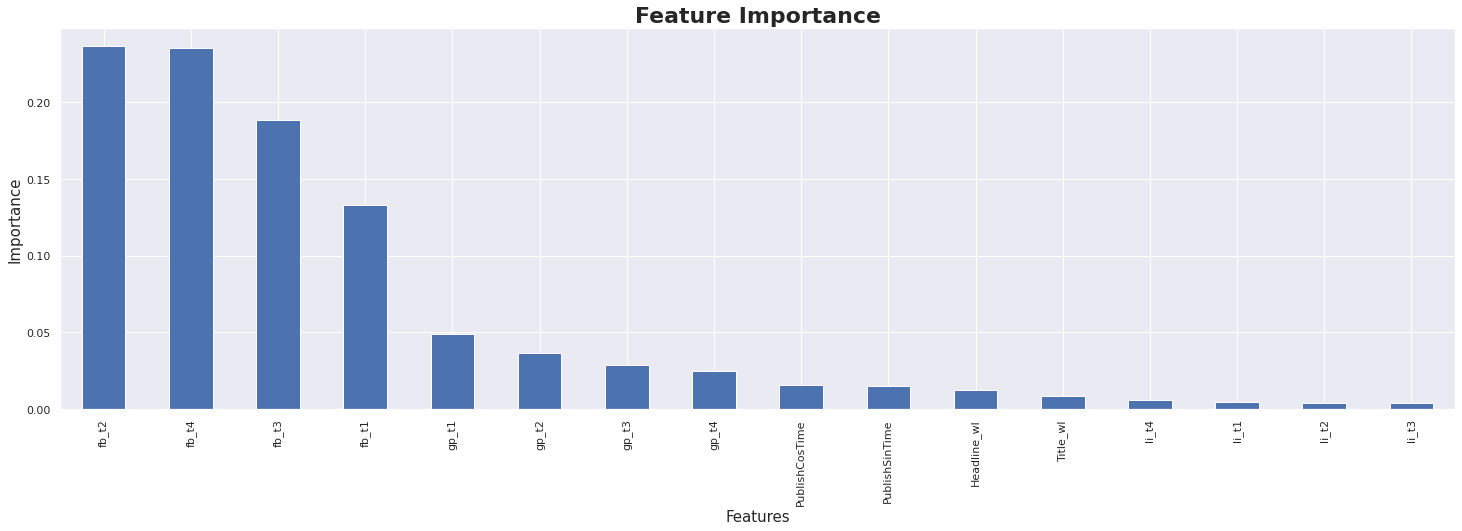

In [ ]:
show_feature_importance(master_df)

## **Correlation Between Features**
---
- The below heatmap can show us the correlation between all the features present in our dataset.
- If we want to train our dataset on Linear Regression model then there are some assumptions related to correlation that we need to satisfy. Let's look at the correlation plot.

In [ ]:
Platform = "Facebook" #@param ["Select Social Media", "Facebook", "GooglePlus", "LinkedIn"]

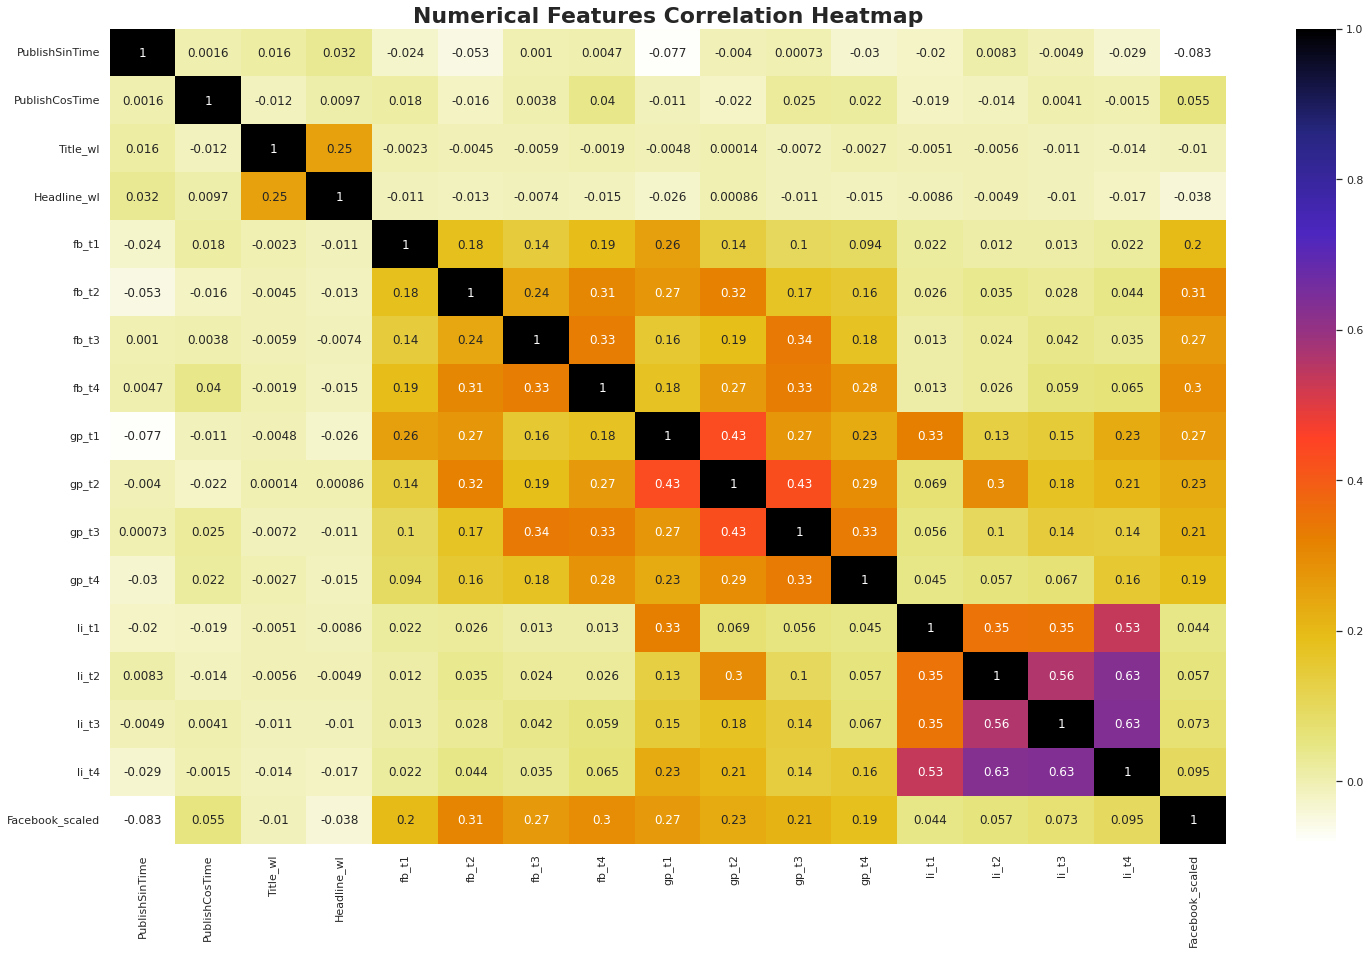

In [ ]:
show_correlation_between_features(master_df, Platform, True)

- Here, we can clearly see that the maximum correlation between features is 0.63, which is not at all a good correlation.
- We can say that the independent features are not correlated to each other. This satisfies one of the assumptions of Linear Regression Model.
- We can also say that dependent and independent features also no at all correlated. This dissatisfies one of the assumptions of Linear Regression Model.
- This implies that we cannot use Linear Regression Model to train this data set.

In [ ]:
# From statsmodels.stats.outliers_influence import variance_inflation_factor
# x = x1_train.drop('Facebook_scaled',1)
# y = x1_train.Facebook_scaled

In [ ]:
# def cal_vif(x):
#     thresh = 2
#     output = pd.DataFrame()
#     k = x.shape[1]
#     vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
#     for i in range(1,k):
#         print('Iteration No.:',i)
#         print(vif)
#         a = np.argmax(vif)
#         print('Max vif is for variable No.:',a)
#         if vif[a]<thresh:
#             break
#         if i==1:
#             output = x.drop(x.columns[a],axis=1)
#             vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
#         elif i>1:
#             output = output.drop(output.columns[a],axis=1)
#             vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
#     return output

# selected_features = cal_vif(x)
# selected_features